# Objective

Applied unsupervised learning techniques to organize global CO2 flooding projects into clusters. Those clusters were used to identify projects that share a similar set of reservoir and fluid parameters. Characteristics and performances of these analogous projects can be used to identify processes and decisions applicable to all. This will enhance operational and technical planning decisions in new or current CO2 flooding projects at field and well levels .





# About The Dataset
The dataset is collated from extensive review and examination of successful pilot/field CO2 flooding projects that were published in Oil and Gas Journal biannual EOR surveys (from 1980 to 2014), SPE publications, DOE reports, and AAPG databases. 

It is a multivariate dataset with 170 rows of data and 12 features.Each row describes a CO2 Flooding project, and each column describes an attribute of the project. The twelve features are field , reservoir and fluid parameters which are selected and extracted because they are commonly available and used for EOR project data analysis. 

The information will be used to categorize global CO2 flooding projects into clusters of similar characteristics that can be referenced as benchmark or analogues for future projects.

The following is a description of the dataset.

**Attribute Information:**

| Position | Feature | Description |Feature Type |
|------:|:-----|---------|---------|
|[, 1]|	Area	|Area, acres|Numerical|
|[, 2]|	Prod_well|	No. of production wells|Numerical|
|[, 3]|	Inj_well|	No. of injection wells|Numerical|
|[, 4]|	Formation|	Formation types (S: Sandstones, Carb: Carbonates)|Categorical|
|[, 5]|	Por|	Porosity, %|Numerical|
|[, 6]|	Perm|	Permeability, md|Numerical|
|[, 7]|	Depth| Depth, ft|Numerical|
|[, 8]|	API|	Oil gravity, oAPI|Numerical|
|[, 9]|	Visc| Oil viscosity, cp|Numerical|
|[,10]|	Temp| Reservoir Temperature, oF|Numerical|
|[,11]|	Prev_prod	|Previous production type (OGI: Other gas injection, None: No prev., Prim: Primary, WF: Waterflood|Categorical|
|[,12]|	Sat_start	|Oil saturation at start of CO2 flooding, % |Numerical|


# Key Skills Demonstrated



*   Data cleaning
*   Dimensionality reduction with PCA
*   Unsupervised clustering
*   Model comparison

# Imports

In [ ]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
import sklearn.cluster as cl
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn import metrics
from sklearn.metrics import davies_bouldin_score

import plotly.express as px
from plotly.offline import iplot
import plotly.graph_objects as go

import joblib

In [ ]:
# Load in the data
filepath = '/content/CO2_projects.csv'
df_orig = pd.read_csv(filepath)


# Descriptive Statistics

In [ ]:
from google.colab import data_table
data_table.DataTable(df_orig)

,ID,Country,State,Latitude,Longitude,Operator,Field,Area,Formation,Depth,API,Temperature,Permeability,Sat_start,Pressure/MMP,Porosity,MMP,Pressure,Viscosity
0,1,US,Wyo.,52.518045,-102.434766,Anadarko,Patrick Draw Monell,5800,Sandstone,5000,43.0,120,30.0,39.00,1.000000,20.00,1200,1200,0.60
1,2,US,Wyo.,53.490519,-103.133331,Anadarko,Salt Creek Southern Unit,570,Sandstone,1750,39.0,105,25.0,32.00,1.000000,17.00,1200,1200,0.60
2,3,US,Wyo.,52.818940,-103.366288,Anadarko,Salt Creek Southern Unit,1325,Sandstone,2200,39.0,112,30.0,32.00,1.000000,18.00,1200,1200,0.60
3,4,US,Wyo.,51.891222,-103.744590,Anadarko,Salt Creek,3500,Sandstone,1900,37.0,105,75.0,39.00,1.000000,18.00,1200,1200,0.60
4,5,US,Wyo.,52.285454,-102.707326,Anadarko,Salt Creek Ph 1-8,6000,Sandstone,1900,37.0,105,75.0,39.00,1.000000,18.00,1200,1200,0.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,173,Canada,Alberta,62.640605,-111.436796,Vikor,Jofrre Viking,480,Sandstone,5075,42.0,133,500.0,36.00,1.133869,13.00,1494,1694,1.14
166,174,Canada,Alberta,63.439322,-112.212683,Vikor,Jofrre Viking,1280,Sandstone,5000,42.0,133,500.0,38.00,1.133869,13.00,1494,1694,1.14
167,177,Hungary,Nagylengyel,56.108517,20.622035,Mol Rt KFV,Nagylengyel,2890,Carbonates,6700,18.0,237,1000.0,48.03,1.125000,1.06,4000,4500,22.00
168,178,Hungary,Nagylengyel,56.865946,21.592354,Mol Rt KFV,Nagylengyel,200,Carbonates,7400,16.0,248,1000.0,48.03,1.125000,2.50,4000,4500,92.00


In [ ]:
df_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170 entries, 0 to 169
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            170 non-null    int64  
 1   Country       170 non-null    object 
 2   State         170 non-null    object 
 3   Latitude      170 non-null    float64
 4   Longitude     170 non-null    float64
 5   Operator      170 non-null    object 
 6   Field         170 non-null    object 
 7   Area          170 non-null    int64  
 8   Formation     170 non-null    object 
 9   Depth         170 non-null    int64  
 10  API           170 non-null    float64
 11  Temperature   170 non-null    int64  
 12  Permeability  170 non-null    float64
 13  Sat_start     170 non-null    float64
 14  Pressure/MMP  170 non-null    float64
 15  Porosity      170 non-null    float64
 16  MMP           170 non-null    int64  
 17  Pressure      170 non-null    int64  
 18  Viscosity     170 non-null    

Create 

In [ ]:
# df['MMP'] = np.where(df.API < 27, 4000, 10)
# df.loc[df.API >=27, 'MMP'] = 3000
# df.loc[df.API >= 30, 'MMP'] = 1200

In [ ]:
# df['Press'] = np.where(df.Temp < 120, df.MMP, 10)
# df.loc[df.Temp >=120, 'Press'] = df.MMP +200
# df.loc[df.Temp >=150, 'Press'] = df.MMP +350
# df.loc[df.Temp >=200, 'Press'] = df.MMP +500

In [ ]:
# df.Press

In [ ]:
desc = df_orig.describe()
# desc.loc['count'] = desc.loc['count'].astype(int).astype(str)
# desc.iloc[1:] = desc.iloc[1:].applymap('{:.0f}'.format)
desc

# Data Pre-processing

In [ ]:
df = df_orig.copy(deep= True)

## Data type conversion 

In [ ]:
# """
# The 'Object' data types Formation first converted to 
# category and then numeric codes for these categories are generated 
# """
# df.Formation = df.Formation.astype('category')
# df["Formation_cat"] = df.Formation.cat.codes
# print(df.Formation.cat.categories)
# print(df.Formation_cat.value_counts(sort= False))

# Dataset visualization

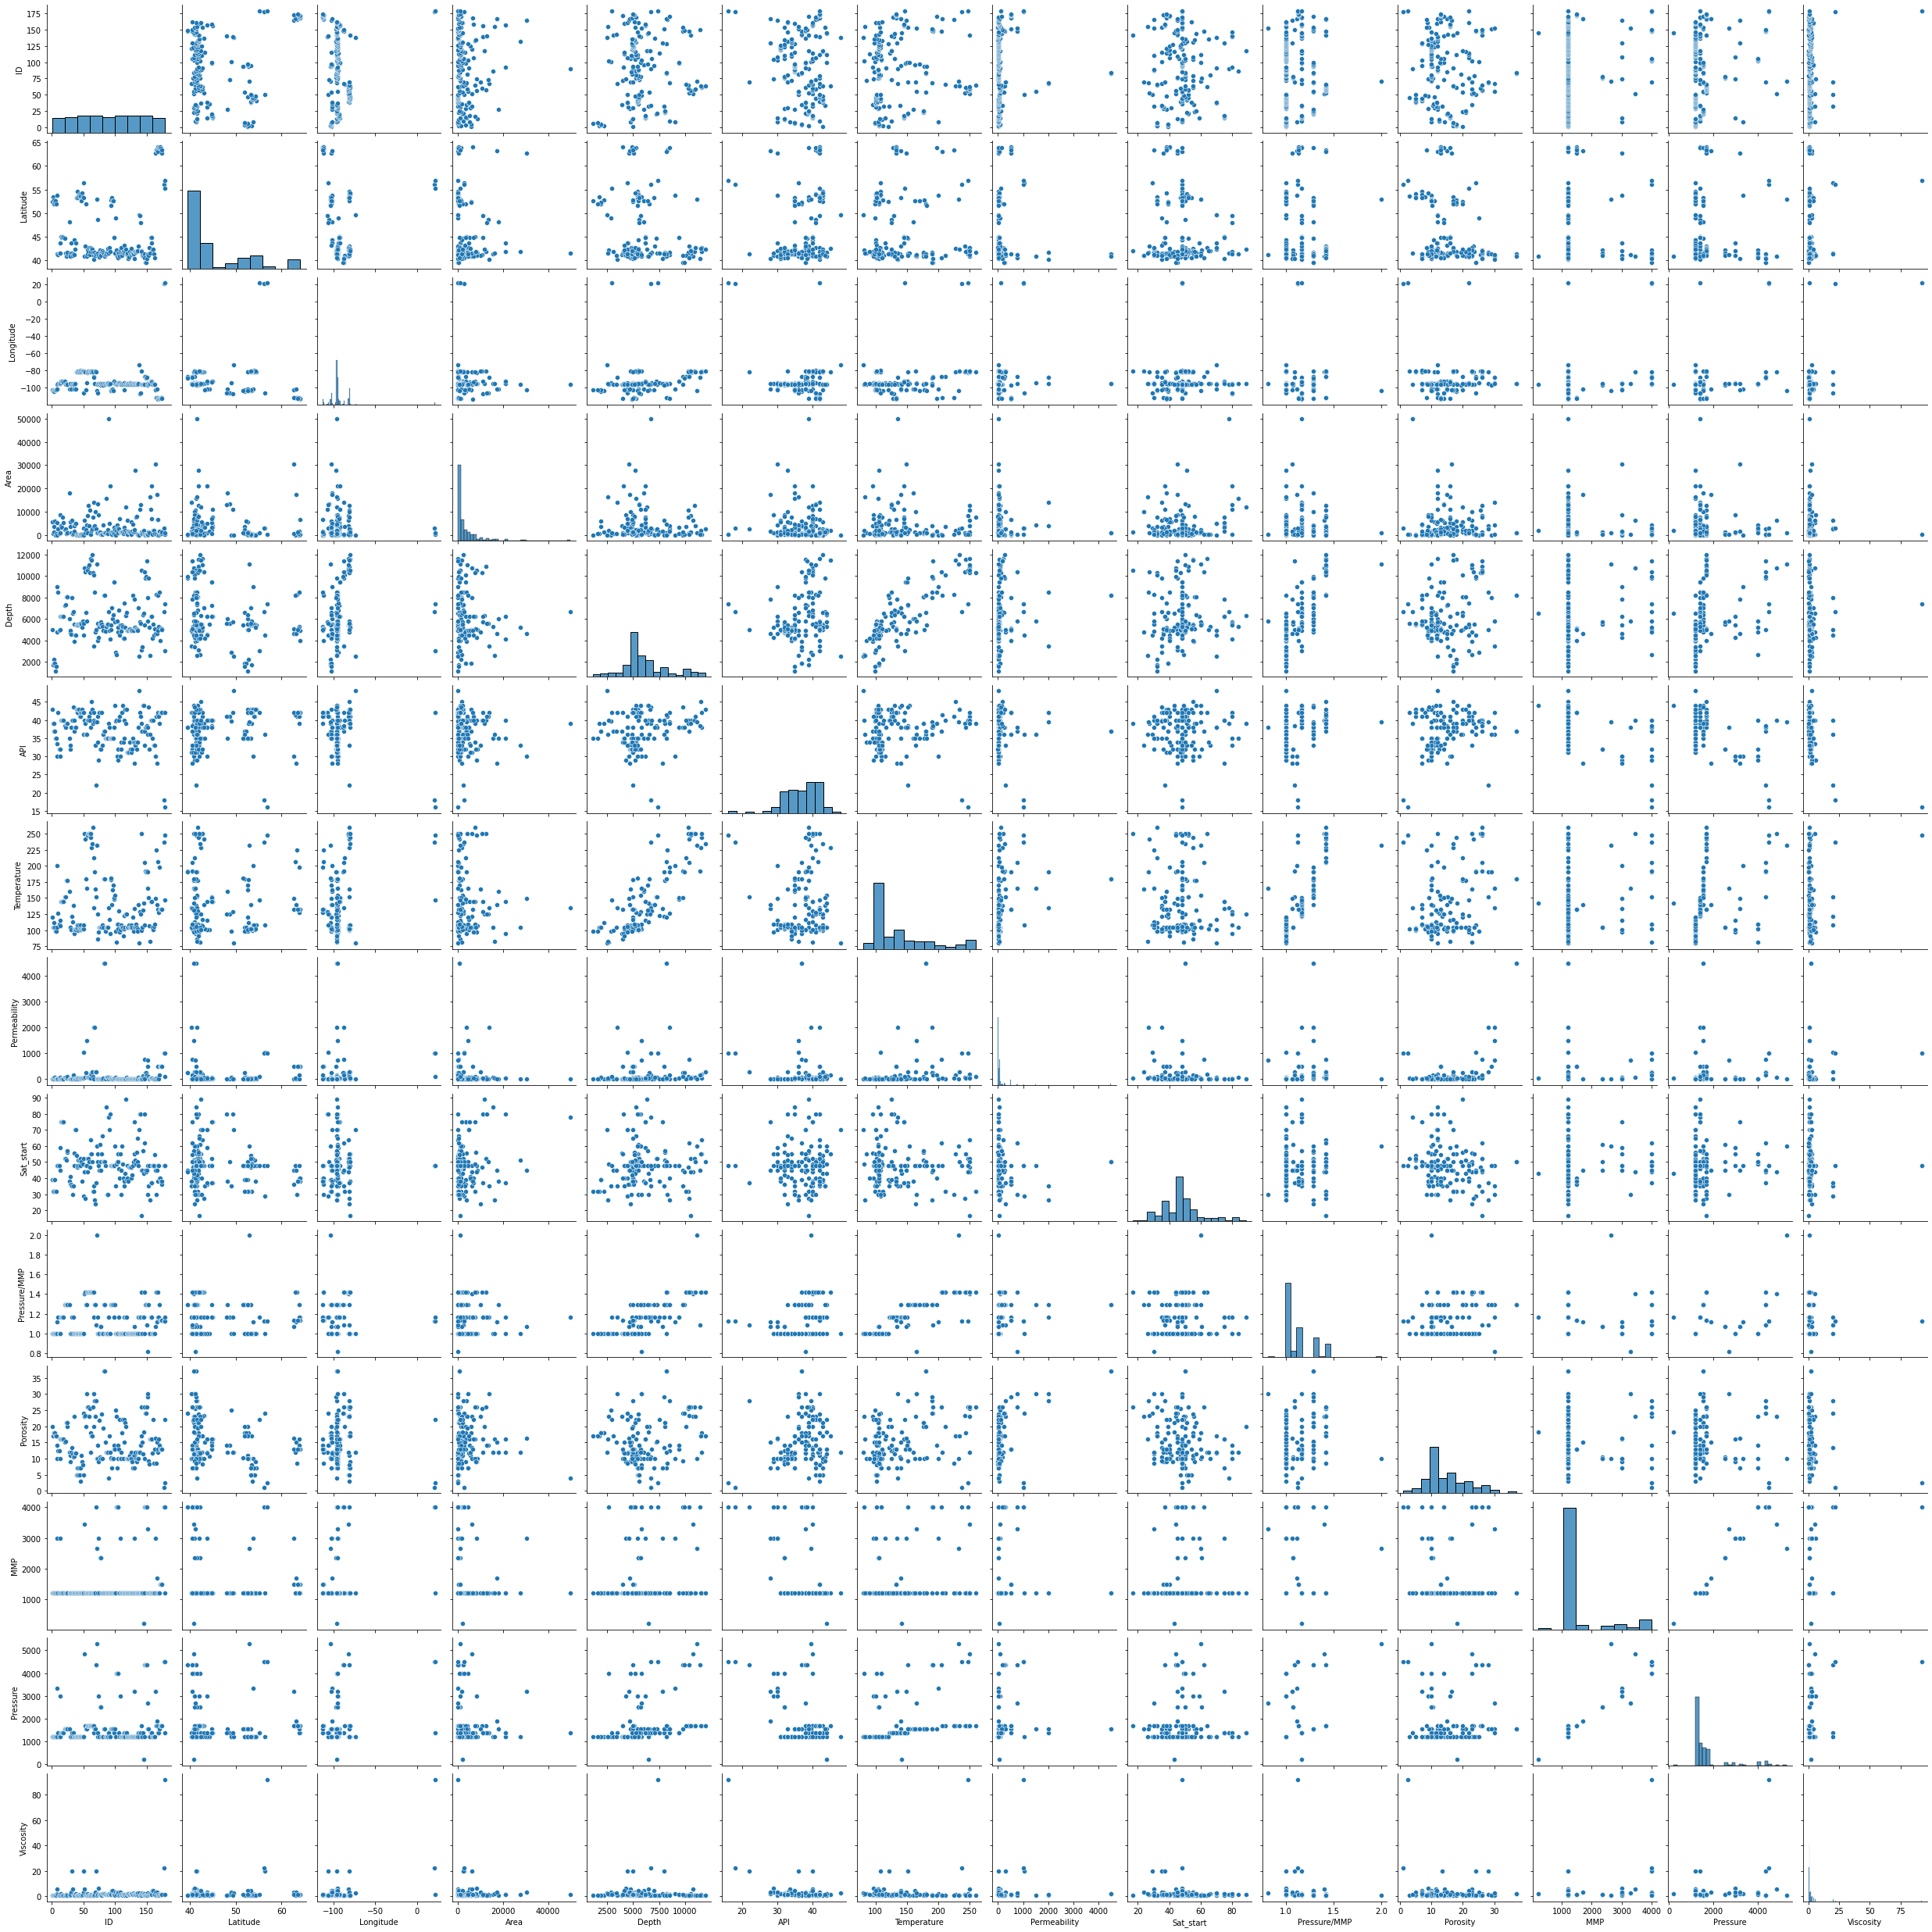

In [ ]:
sns.pairplot(df)

## Handling outliers

Rather than delete the outlier rows in these features, the values of these rows are capped to an amount grreater than the 3rd quantile vale for that feature. 
This is done so that these values can have a chance to contribute their importance to the features without making the distribution skewed.

In [ ]:
Outlier_col = [
               'Porosity', 
               'Permeability', 
               'Viscosity', 
               'Pressure',
               'Pressure/MMP',
              #  'MMP'
               ] # columns identified in pairplot as having large outliers

for col in Outlier_col:
  Q1=df[col].quantile(0.25)
  Q3=df[col].quantile(0.75)
  IQR=Q3-Q1
  val = Q3+1.5*IQR
  val2 = Q1-IQR
  # val = df_out[col].quantile(0.75)  # upper limit calculated by increasing 3rd quantile value by 50%
  df[col] = np.where(df[col] > val , val, df[col])   # replacing the outliers
  # df.loc[df[col] > Q3, col] = Q3
Q1=df['Pressure'].quantile(0.25)
Q3=df['Pressure'].quantile(0.75)
IQR=Q3-Q1
val2 = Q1-IQR
df['Pressure'] = np.where(df['Pressure'] < val2 , val2, df['Pressure'])   # replacing the outliers

In [ ]:
# Drop identifier columns 
col_drop = ['ID',	'Country',	'Operator',	'Field','Formation', 'Area', 'State', 'Latitude', 'Longitude',
            # 'Pressure', 
            'MMP',
            # 'Pressure/MMP',
            'Sat_start',
            # 'Depth'
            ]
df = df.drop (columns= col_drop, axis= 1)

# Seperate identifier columns for later concatenation
df_id = df_orig[col_drop]

The distribution shows that the influence of outliers have been reduced in the columns.

In [ ]:
desc = df.describe()
desc.loc['count'] = desc.loc['count'].astype(int).astype(str)
desc.iloc[1:] = desc.iloc[1:].applymap('{:.0f}'.format)
desc


,Depth,API,Temperature,Permeability,Pressure/MMP,Porosity,Pressure,Viscosity
count,170,170,170,170,170,170,170,170
mean,6091,37,137,50,1,15,1486,1
std,2237,5,46,57,0,6,387,1
min,1150,16,80,2,1,1,742,0
25%,4900,34,104,5,1,10,1200,1
50%,5500,38,114,29,1,13,1400,1
75%,6950,41,152,69,1,18,1658,2
max,11950,48,260,166,1,30,2345,4


## Correlation

An heatmap is plotted to get a feel for how the correlations between the different features compare to one another. 

In [ ]:
df.corr()

,Depth,API,Temperature,Permeability,Pressure/MMP,Porosity,Pressure,Viscosity
Depth,1.000000,0.192540,0.826110,0.363961,0.774637,0.249930,0.423874,-0.175308
API,0.192540,1.000000,0.083345,0.157201,0.274519,0.242460,-0.310813,-0.459648
Temperature,0.826110,0.083345,1.000000,0.527775,0.886473,0.392337,0.494796,-0.120704
Permeability,0.363961,0.157201,0.527775,1.000000,0.452132,0.443355,0.338392,-0.062212
Pressure/MMP,0.774637,0.274519,0.886473,0.452132,1.000000,0.380895,0.370579,-0.228952
Porosity,0.249930,0.242460,0.392337,0.443355,0.380895,1.000000,0.169975,-0.129157
Pressure,0.423874,-0.310813,0.494796,0.338392,0.370579,0.169975,1.000000,0.162710
Viscosity,-0.175308,-0.459648,-0.120704,-0.062212,-0.228952,-0.129157,0.162710,1.000000


Text(0.5, 1.05, 'Correlation of Features')

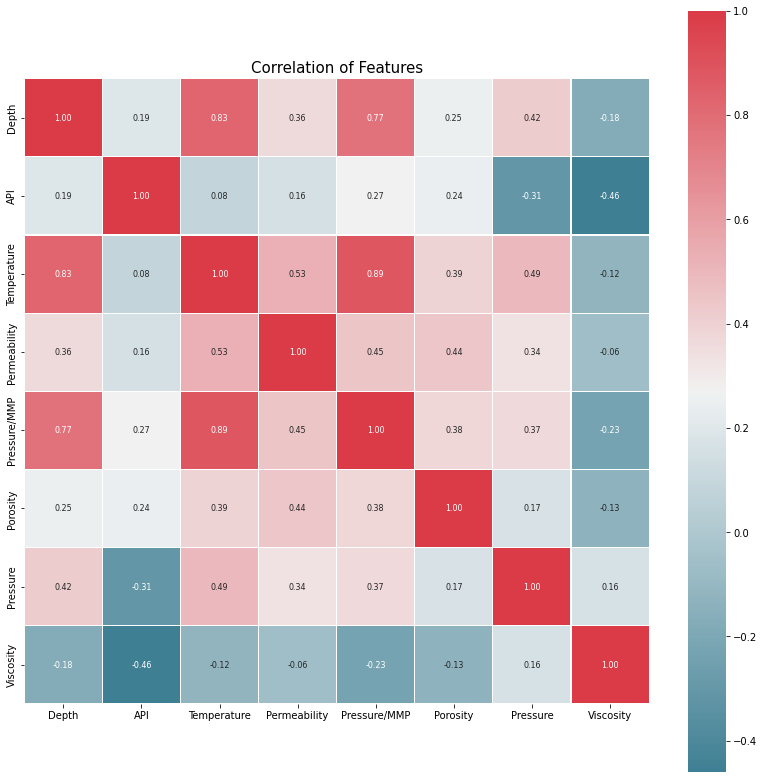

In [ ]:
corr = df.corr()
colormap = sns.diverging_palette(220, 10, as_cmap = True)
plt.figure(figsize=(14,14))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 8},
            cmap = colormap, linewidths=0.1, linecolor='white')
plt.title('Correlation of Features', y=1.05, size=15)


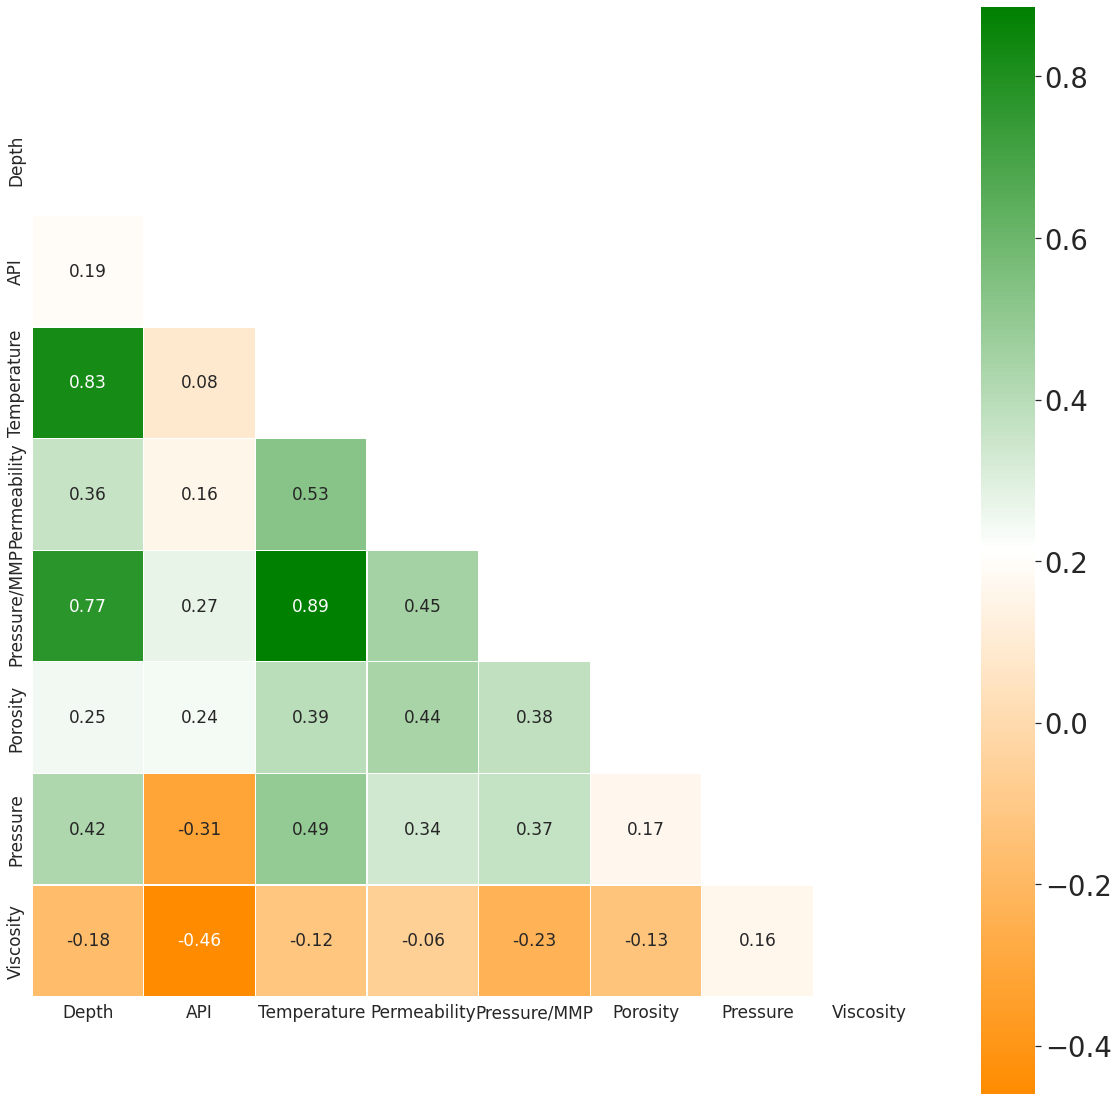

In [ ]:
corr = df.corr()


# colormap = sns.diverging_palette(260, 1, as_cmap = True)
from matplotlib.colors import LinearSegmentedColormap
colormap = LinearSegmentedColormap.from_list(name='test', colors=['darkorange','white','green'])

mask = np.zeros_like(corr)

mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(20, 20))
    sns.set(font_scale=2.5)
    ax = sns.heatmap(corr, 
                     cmap=colormap,
                    #  cmap='YlGnBu',
                     annot= True,
                     mask=mask,
                    #  vmin=-1, vmax=1, 
                      fmt= '.2f',
                     annot_kws={'size': 17},
                     linewidths=0.1, linecolor='white',
                     square=True)
        # get label text
    _, ylabels = plt.yticks()
    _, xlabels = plt.xticks()
    ax.set_yticklabels(ylabels, size=17)

    # set the x-axis ticklabel size
    ax.set_xticklabels(xlabels, size=17)


Figure  depicts the correlation between different columns. Yellow and shades of green show positive correlations while Purple and shades of blue show negatively correlated features. 

Depth and Temperature have high positive correlation. PCA will be used, therefore the value from each feature will be extracted.


Next pairplot of the features is made to identify distibutions and outliers

In [ ]:
# sns.pairplot(df)

## Standardization

The decision to standardize the data prior to a PCA on the covariance matrix depends on the measurement scales of the original features. Since PCA yields a feature subspace that maximizes the variance along the axes, it makes sense to standardize the data, especially, since it was measured on different scales. The data will be transformed onto unit scale (mean=0 and variance=1), which is a requirement for the optimal performance of many machine learning algorithms.
The data is standardized using sklearn's RobustScaler.

In [ ]:
from sklearn.preprocessing import RobustScaler
trans = RobustScaler(quantile_range=(25,75))
df_std = trans.fit_transform(df)


In [ ]:
# # Standardize the data to have a mean of ~0 and a variance of 1
# trans = StandardScaler()
# df_std = trans.fit_transform(df)



## Bartlett Sphericity Factor

This test is to determine if the features will benefit from dimensionality reduction

In [ ]:
pip install factor-analyzer

     |████████████████████████████████| 41 kB 417 kB/s 
  Created wheel for factor-analyzer: filename=factor_analyzer-0.4.0-py3-none-any.whl size=41455 sha256=f689c3e56d1eb4a84cecfa22ac21643739f2773e0dbd78d454923d2a3facb4c6
  Stored in directory: /root/.cache/pip/wheels/ac/00/37/1f0e8a5039f9e9f207c4405bbce0796f07701eb377bfc6cc76
Successfully built factor-analyzer


In [ ]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
chi_square_value,p_value=calculate_bartlett_sphericity(df_std)
chi_square_value, p_value

(740.0462467984491, 8.113023617131076e-138)

With a p-value almost 0, the parameters are related and are therefore suitable for structure detection.

# PCA

### Number of Principal Component Determination 

Eigendecomposition - Computing Eigenvectors and Eigenvalues

The eigenvectors and eigenvalues of a covariance (or correlation) matrix represent the "core" of a PCA: The eigenvectors (principal components) determine the directions of the new feature space, and the eigenvalues determine their magnitude. In other words, the eigenvalues explain the variance of the data along the new feature axes.

Therefore, an eigendecomposition is performed using covariance matrix approach

In [ ]:
cov_mat = np.cov(df_std.T)

eig_vals, eig_vecs = np.linalg.eig(cov_mat)

print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Eigenvectors 
[[-0.55016718 -0.0021942  -0.42988938  0.17164819 -0.59506175 -0.32589417
   0.13939157 -0.05751327]
 [-0.08336461 -0.55195378  0.04225031 -0.24537643  0.38573802 -0.66417731
   0.13145359 -0.13855435]
 [-0.5149343   0.08122967 -0.08591245 -0.73930722  0.14677882  0.37434359
   0.11181555 -0.01041311]
 [-0.31137864  0.01318909  0.65006183  0.10333355 -0.15706328  0.02968265
  -0.2128572  -0.63146897]
 [-0.45323011 -0.10157239 -0.12711245  0.59185443  0.5672401   0.27163524
   0.14896736  0.0088294 ]
 [-0.21814722 -0.17007745  0.58961026  0.04990027 -0.20120268 -0.0147489
   0.27822354  0.67471977]
 [-0.2587029   0.53787985  0.05945519 -0.01695638  0.26310435 -0.42277455
  -0.55082829  0.29759301]
 [ 0.09121122  0.60000998  0.12694859  0.0022574   0.13938096 -0.24270505
   0.7088495  -0.18640571]]

Eigenvalues 
[3.1314469  0.99937703 0.7293462  0.06371569 0.20078419 0.24433266
 0.40152903 0.37218802]


In [ ]:
for ev in eig_vecs.T:
    np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))
print('Everything ok!')

Everything ok!


In [ ]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
print('Eigenvalues in descending order:')
for i in eig_pairs:
    print(i[0])

Eigenvalues in descending order:
3.1314469010211763
0.9993770329500976
0.7293462010512782
0.40152902730775497
0.37218802405106205
0.24433266055437347
0.20078419498378666
0.06371568563838785


In [ ]:
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
cum_var_exp

array([ 50.97818295,  67.24747534,  79.12081864,  85.65748391,
        91.71649426,  95.69409167,  98.9627447 , 100.        ])

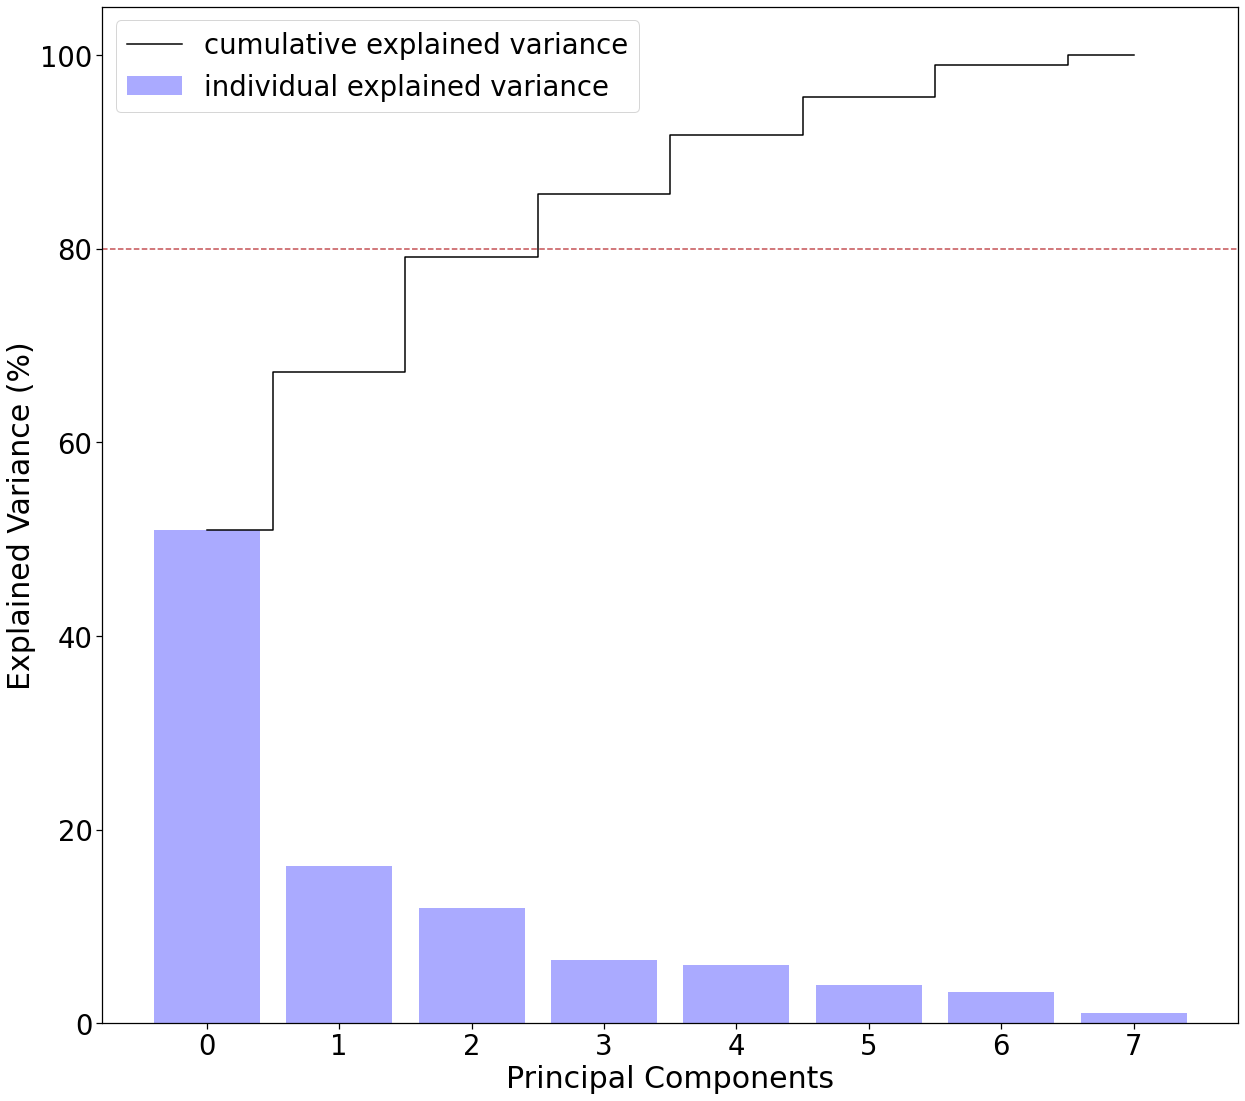

In [ ]:
plt.style.context('seaborn-whitegrid')
plt.figure(figsize=(18,16))
plt.bar(range(len(var_exp)), var_exp, alpha=0.3333, align='center', label='individual explained variance', color = 'blue')
plt.step(range(len(cum_var_exp)), cum_var_exp, where='mid',label='cumulative explained variance', color = 'black')
plt.axhline(y=80, xmax= 1, color='r', linestyle='--')
plt.ylabel('Explained Variance (%)')
plt.xlabel('Principal Components')
plt.legend(loc='best')
plt.tight_layout()

Figure shows that the first 5 components explain the majority of the variance in our data. Preserving approximately 85% of the variance, we select 5 features.


### PCA Implementation

Having roughly identified how many components/dimensions we would like to project on, let's now implement sklearn's PCA module.

The first line of the code contains the parameters "n_components" which states how many PCA components we want to project the dataset onto. Since we are going implement PCA with 5 components, therefore we set n_components = 5.

The second line of the code calls the "fit_transform" method, which fits the PCA model with the data df_std and applies the dimensionality reduction on this dataset.

In [ ]:
# Create a PCA instance: pca
pca = PCA(n_components=3
          )
df_trans= pca.fit_transform(df_std)

print("original shape:   ", df_std.shape)
print("transformed shape:", df_trans.shape)

original shape:    (170, 8)
transformed shape: (170, 3)


In [ ]:
#Assign labels to components
components = pca.components_.T * np.sqrt(pca.explained_variance_)

Compo = pd.concat([pd.DataFrame(df.columns), pd.DataFrame(components)], axis=1)


Compo.columns = ['Features','Principal Component 1', 'Principal Component 2',
                               'Principal Component 3',
                               ]
                               
Compo

,Features,Principal Component 1,Principal Component 2,Principal Component 3
0,Depth,0.973570,-0.002194,-0.367133
1,API,0.147521,-0.551782,0.036083
2,Temperature,0.911222,0.081204,-0.073371
3,Permeability,0.551012,0.013185,0.555164
4,Pressure/MMP,0.802031,-0.101541,-0.108556
5,Porosity,0.386031,-0.170024,0.503538
6,Pressure,0.457798,0.537712,0.050776
7,Viscosity,-0.161406,0.599823,0.108416


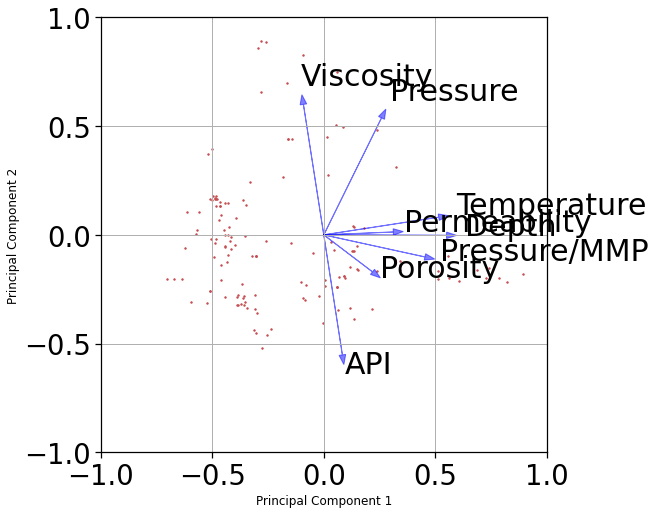

In [ ]:
def myplot(score,coeff,labels=df.columns):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    # 
    scalex = 2.0/(xs.max() - xs.min())
    scaley = 2.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex, ys * scaley, color= 'r', s= 2 )
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'blue',alpha = 0.5, shape= 'full', head_width = 0.03)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'black', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'black')
plt.figure(figsize=(8,8))
plt.xlim(-1.0,1.0)
plt.ylim(-1.0,1.0)
plt.xlabel("Principal Component {}".format(1), size= 12)
plt.ylabel("Principal Component {}".format(2),  size= 12)
plt.grid()

#Call the function. Use only the 2 PCs.
myplot(df_trans[:,0:2],np.transpose(pca.components_[0:2, :]))
plt.show()

### Projection Onto the New Feature Space

To illustrate the transformation of the data onto the new subspace, the plot of Oil gravity,API is transformed on the new subspace as shown in the figure below.


In [ ]:
# df['Visc1'] = pd.qcut(df.Visc, q= [0,0.25,0.75,1.0], labels=['Low','Medium','High'])# create bins from quantile 
# y = df['Visc1'].values

In [ ]:
# with plt.style.context('seaborn-whitegrid'):
#     plt.figure(figsize=(6, 4))
#     for lab, col in zip(('Low', 'Medium', 'High'),
#                         ('blue', 'red', 'green')):
#         plt.scatter(df_trans[y==lab, 0],
#                     df_trans[y==lab, 1],
#                     label=lab,
#                     c=col)
#     plt.xlabel('Principal Component 1')
#     plt.ylabel('Principal Component 2')
#     plt.legend(loc='lower right')
#     plt.tight_layout()
#     plt.show()


After applying the linear PCA transformation, a lower dimensional subspace (from 12D to 5D in this case), is obtained where the samples are “most spread” along the new feature axes.

In [ ]:
# from sklearn import manifold
# # Implement Isomap here. Reduce the dataframe df down
# # to THREE components.
# #
# iso = manifold.Isomap(n_neighbors=8, n_components=4)
# iso.fit(df_std)
# manifold = iso.transform(df_std)

# with plt.style.context('seaborn-whitegrid'):
#     plt.figure(figsize=(6, 4))
#     for lab, col in zip(('Low', 'Medium', 'High'),
#                         ('blue', 'red', 'green')):
#         plt.scatter(manifold[y==lab, 0],
#                     manifold[y==lab, 1],
#                     label=lab,
#                     c=col)
#     plt.xlabel('Principal Component 1')
#     plt.ylabel('Principal Component 3')
#     plt.legend(loc='lower right')
#     plt.tight_layout()
#     plt.show()

# df = df.drop('Visc1', axis=1)

# Algorithm Comparison

A Utility function is first created that can be used to plot the data and evaluate the clustering algorithms

### Utility function

In [ ]:
def plot_clusters(data, algorithm, args, kwds):
  """
  This utility function is outputs a scatterplot of the first two columns
  of the input dataframe, data, as a scatterplot.
  It also outputs evaluation metric scores - Silhouette, Calinski Harabasz, and Davies Bouldin.
  These are metrics used to evaluate cluster algorithms when the ground truth is not known.
  See https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation for details

  """
  model = algorithm(*args, **kwds).fit_predict(data)
         
  clusters = np.unique(model)
  # create scatter plot for samples from each cluster
  for cluster in clusters:
   # get row indexes for samples with this cluster
   row_ix = np.where(model == cluster)
   # create scatter of these samples
   pyplot.scatter(data[row_ix, 0], data[row_ix, 1])
    # show the plot
  pyplot.title('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=16)
  pyplot.show()

  print('Silhouette score is', metrics.silhouette_score(data, model, metric='euclidean'))
  print('Calinski Harabasz score is', metrics.calinski_harabasz_score(data, model))
  print('Davies Bouldin score is', davies_bouldin_score(data, model))




In [ ]:
def plot_figures(ks, measure, ylabel_title):
  """Plots figures for optimal number of clusters determination
  :params:  ks - a range of number of clusters,
  measure - a list of the measures to plot,
  ylabel_title - a string showing the ylabel title of the figure 

  :returns: a plot 
  """
  plt.figure(figsize=(18,12)) 
  plt.plot(ks, measure, '-o', color='red', lw = 4, markersize=10)
  plt.axvline(x=5, color='b', linestyle='--', lw = 4)
  plt.xlabel('Number of Clusters, k')
  plt.ylabel(ylabel_title)
  plt.xticks(ks)
  plt.show()



## KMeans

Centroid-based clustering

### Optimal Cluster Number Determination



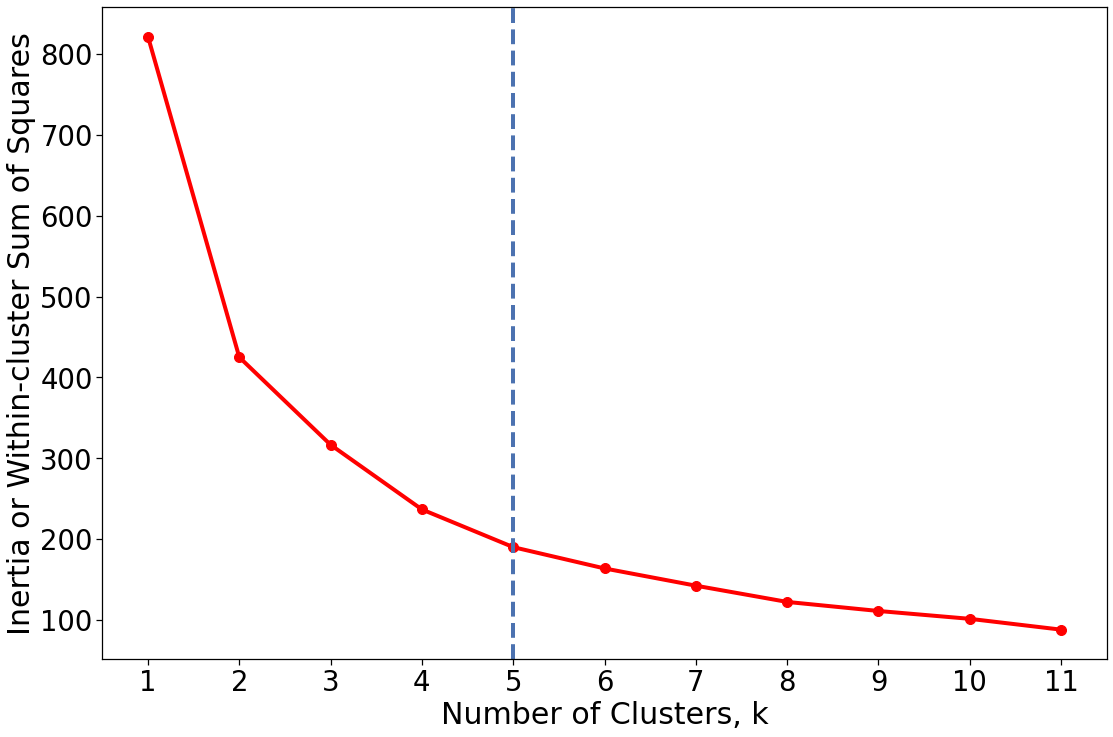

In [ ]:
# Elbow Method

ks = range(1, 12)
measure = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model1 = cl.KMeans(n_clusters=k, init ='k-means++', max_iter=300, n_init=10,random_state=42)
    
    # Fit model to samples
    model1.fit(df_trans)
    
    # Append the inertia to the list of inertias
    measure.append(model1.inertia_)

plot_figures(ks, measure, 'Inertia or Within-cluster Sum of Squares')


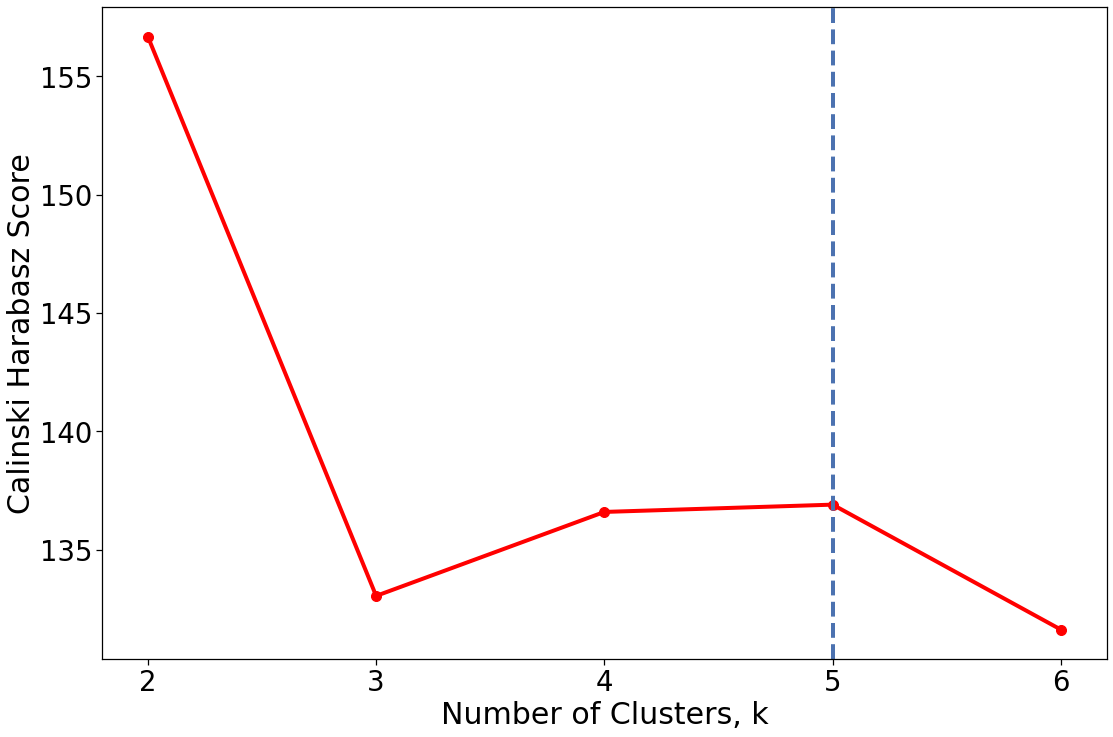

In [ ]:
# Calinski Harabasz Score
ks = range(2, 7)
measure = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = cl.KMeans(n_clusters=k, random_state=42)
    
    # Fit model to samples
    model.fit(df_trans)
        
    # Append the inertia to the list of inertias
    # db.append(davies_bouldin_score(df_trans, model.labels_))
    measure.append(metrics.calinski_harabasz_score(df_trans, model.labels_))
    
plot_figures(ks, measure, 'Calinski Harabasz Score')



Using Silhouette Score method to select number of cluster

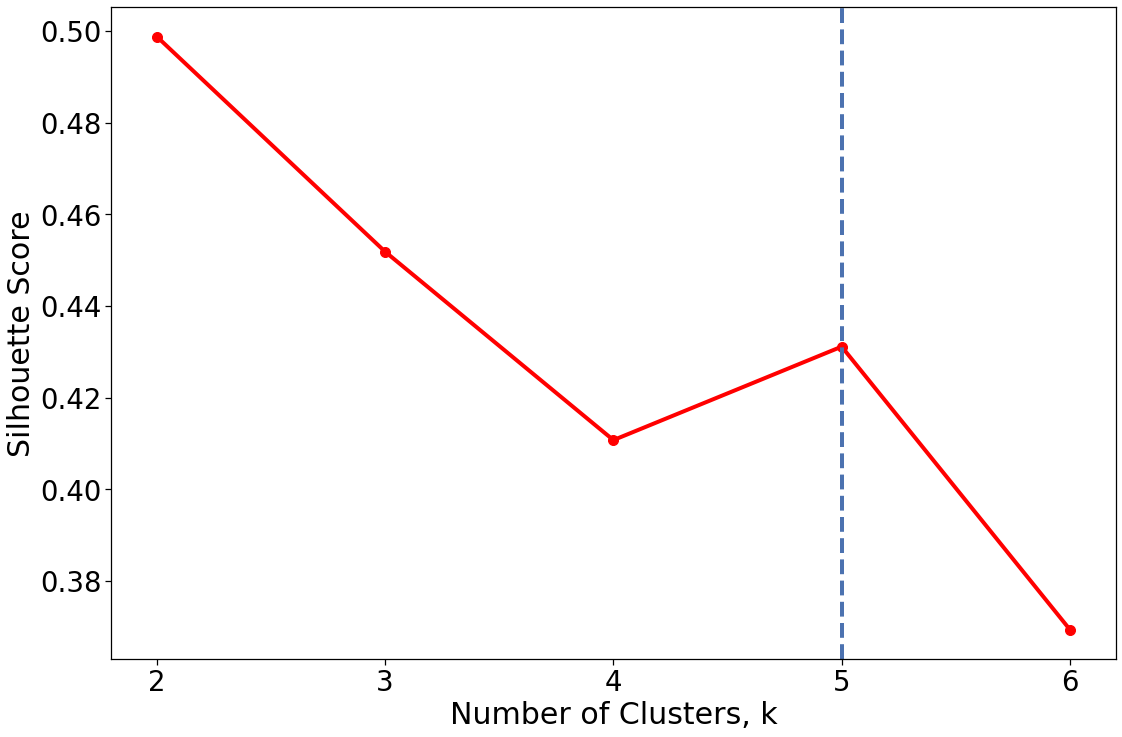

In [ ]:
# Silhouette Score method

ks = range(2, 7)
measure = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = cl.KMeans(n_clusters=k, random_state=42)
    
    # Fit model to samples
    model.fit(df_trans)
        
    # Append the inertia to the list of inertias
    measure.append(silhouette_score(df_trans, model.labels_))
    
plot_figures(ks, measure, 'Silhouette Score')

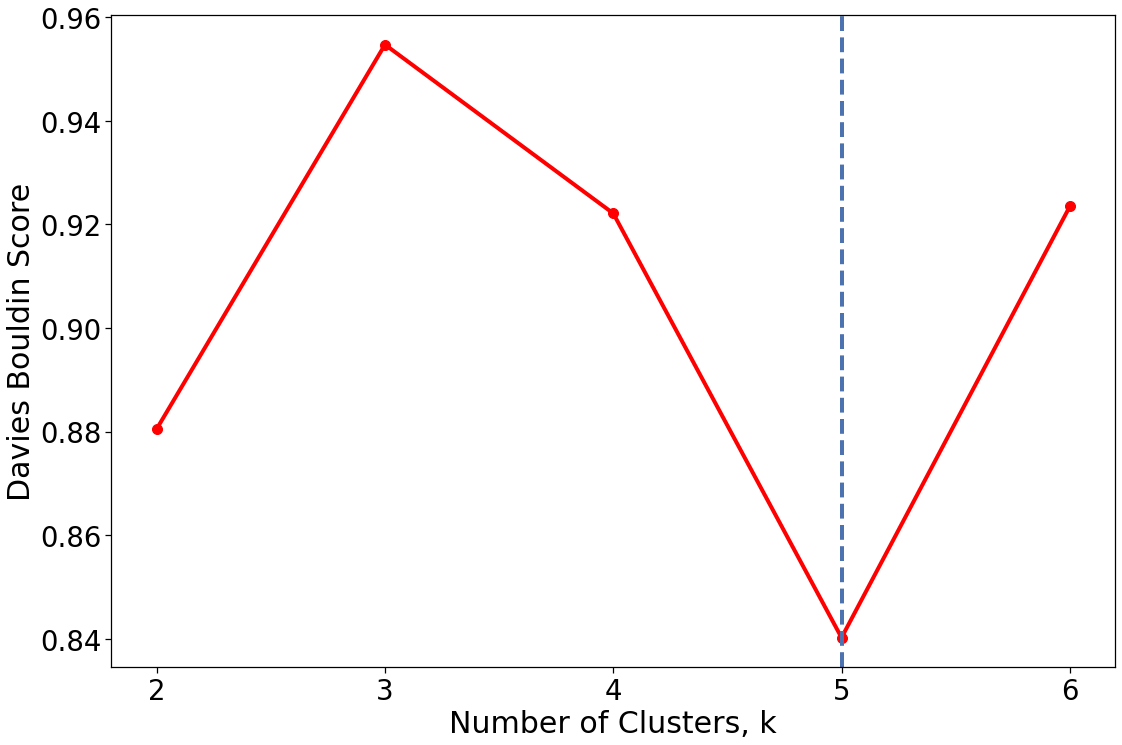

In [ ]:
# Davies Bouldin Score
ks = range(2, 7)
measure = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = cl.KMeans(n_clusters=k, random_state=42)
    
    # Fit model to samples
    model.fit(df_trans)
        
    # Append the inertia to the list of inertias
    measure.append(davies_bouldin_score(df_trans, model.labels_))
    
plot_figures(ks, measure, 'Davies Bouldin Score')

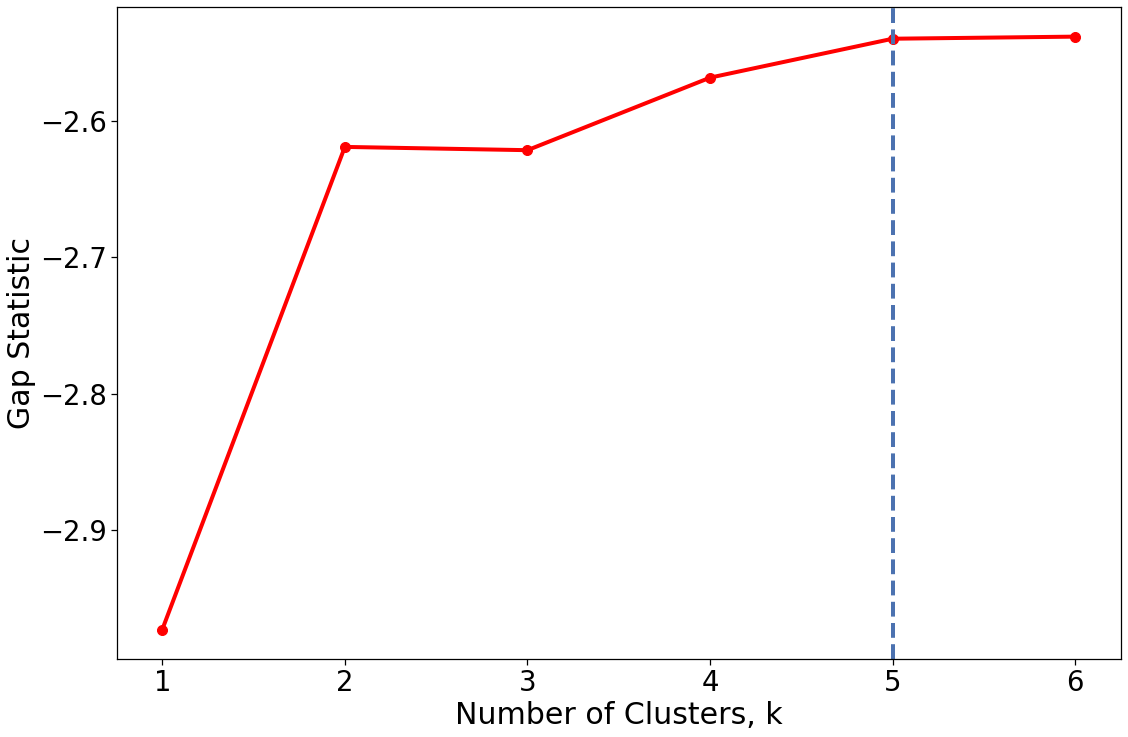

In [ ]:
# Gap Statistic

def optimalK(data, nrefs=3, maxClusters=15):
    """
    Calculates KMeans optimal K using Gap Statistic 
    Params:
        data: ndarry of shape (n_samples, n_features)
        nrefs: number of sample reference datasets to create
        maxClusters: Maximum number of clusters to test for
    Returns: (gaps, optimalK)
    """
    gaps = np.zeros((len(range(1, maxClusters)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
    for gap_index, k in enumerate(range(1, maxClusters)):
    # Holder for reference dispersion results
            refDisps = np.zeros(nrefs)
    # For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
            for i in range(nrefs):
                
                # Create new random reference set
                randomReference = np.random.random_sample(size=data.shape)
                
                # Fit to it
                km = cl.KMeans(k, random_state=42)
                km.fit(randomReference)
                
                refDisp = km.inertia_
                refDisps[i] = refDisp
    # Fit cluster to original data and create dispersion
            km = cl.KMeans(k, random_state=42)
            km.fit(data)
            
            origDisp = km.inertia_
    # Calculate gap statistic
            gap = np.log(np.mean(refDisps)) - np.log(origDisp)
    # Assign this loop's gap statistic to gaps
            gaps[gap_index] = gap
            
            resultsdf = resultsdf.append({'clusterCount':k, 'gap':gap}, ignore_index=True)
    return (gaps.argmax() + 1, resultsdf)

score_g, df = optimalK(df_trans, nrefs=5, maxClusters=7)

plot_figures(df['clusterCount'], df['gap'], 'Gap Statistic')

### Implementation

In [ ]:
#K-Means without PCA
#plot_clusters(df_std, cl.KMeans, (), {'n_clusters':3, 'init':'k-means++', 'max_iter' : 300, 'n_init' : 10, 'random_state': 100})

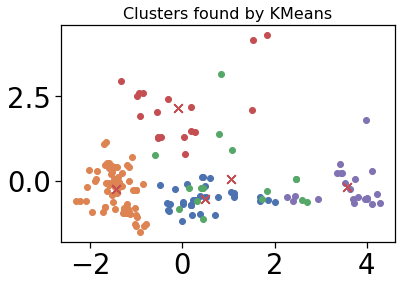

In [ ]:
model = cl.KMeans(n_clusters=5, init= 'k-means++',
                     max_iter = 300, n_init=10,random_state=42)
                     
kmeans= model.fit_predict(df_trans)

kmeans_labels = model.labels_

centroids = model.cluster_centers_
       
clusters = np.unique(kmeans)
# create scatter plot for samples from each cluster
for cluster in clusters:
  # get row indexes for samples with this cluster
  row_ix = np.where(kmeans == cluster)
  # create scatter of these samples
  pyplot.scatter(df_trans[row_ix, 0], df_trans[row_ix, 1])
  plt.scatter(centroids[:, 0], centroids[:, 1], marker="x", s=70, linewidths=3,
            color="r", zorder=10)
  # show the plot
pyplot.title('Clusters found by {}'.format(str(cl.KMeans.__name__)), fontsize=16)
pyplot.show()



In [ ]:
print('Silhouette score is', metrics.silhouette_score(df_trans, kmeans, metric='euclidean'))
print('Calinski Harabasz score is', metrics.calinski_harabasz_score(df_trans, kmeans))
print('Davies Bouldin score is', davies_bouldin_score(df_trans, kmeans))

Silhouette score is 0.43116382160645955
Calinski Harabasz score is 136.90369189701664
Davies Bouldin score is 0.8401919336494469


## K-Median

In [ ]:
def Kmedian(data, k, random_state = 0):
    
    '''
    Input - 
    data: The data in an array and not as a dataframe
    k: the number of clusters you require
    
    Output - depending on the breaking condition
    mu_new or mu: centroids of the clusters 
    assignment_new or assignment: the cluster assignment for each data point
    J_new or J_old: The loss value corresponding to a particular k (number of clusters)
    '''
    
    np.random.seed(random_state)
    # Randomly initializing cluster centroid from the data
    mu = data[np.random.randint(data.shape[0], size = k),:] 
    
    #Taking 1000 iterations as a maximum iterations if the algorithm doesn't converge
    for a in range(1000):
        
        distance_vector = np.zeros((k,data.shape[0]))
        for i in range(k):
            for j in range(data.shape[0]):
                #Calculating the manhattan distance of culster centroid with the data points
                distance_vector[i,j] = np.abs(mu[i] - data[j]).sum()

        #Assigning data points to the cluster based on its minimum distance from the centroid
        assignment = np.argmin(distance_vector, axis = 0)
    
        #Separating the index of the data points according to the cluster it is assigned
        index_cluster = [np.argwhere(i==assignment) for i in np.unique(assignment)]
    
        idx = []
        for i in range(k):
            idx1 = []
            for j in range(len(index_cluster[i])):
                idx1.append(index_cluster[i][j][0])
            idx.append(np.array(idx1))
    
        idx = np.array(idx)
    
        J_old = 0
        #Calculating cost function for the old assignment
        for i in range(k):
            for j in range(len(index_cluster[i])):
                J_old += np.abs(mu[i] - data[index_cluster[i][j][0]]).sum()
    
        J_old = J_old/data.shape[0]
    
        sorted_idx = [] #Sorting in ascending order based on the distance from the centroid
        
        #Calculating new centroid
        mu_new = np.zeros((k,data.shape[1]))
        for i in range(k):
            sorted_idx.append(idx[i][np.argsort(distance_vector[i, idx[i]])])
            mu_new[i, :] = np.median(data[sorted_idx[i]], axis = 0)
    
        distance_vector_new = np.zeros((k,data.shape[0]))
        for i in range(k):
            for j in range(data.shape[0]):
                #Calculating the manhattan distance of culster centroid with the data points
                distance_vector_new[i,j] = np.abs(mu_new[i] - data[j]).sum()
    
        #Assigning data points to the cluster based on its minimum distance from the centroid
        assignment_new = np.argmin(distance_vector_new, axis = 0)
    
        #Separating the index of the data points according to the cluster it is assigned
        index_cluster_new = [np.argwhere(i==assignment_new) for i in np.unique(assignment_new)]
    
        J_new = 0
        #Calculating cost function for the old assignment
        for i in range(k):
            try:
                for j in range(len(index_cluster_new[i])):
                    J_new += np.abs(mu_new[i]-data[index_cluster_new[i][j][0]]).sum()
            except:
                print('empty cluster')
            finally:
                J_new += 0
        J_new = J_new/data.shape[0]
        
        #Condition to break the initial for loop, convergence is achieved if the difference between the old and new cost function is greater than 0 and less than 1
        if (J_old - J_new) >=0 and (J_old - J_new) <1:
            return mu_new, assignment_new, J_new
            break
        #If old - new cost function is less than 0 then new cost is higher than the old cost thus return the older assignment 
        elif (J_old - J_new) <0:
            return mu, assignment, J_old
            break
        #Here convergence is not achieved thus assign new assignment as old assignment and continue till convergence is achieved
        else:            
            mu = mu_new
    
    return mu_new, assignment_new, J_new

### Optimal Cluster Number Determination

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



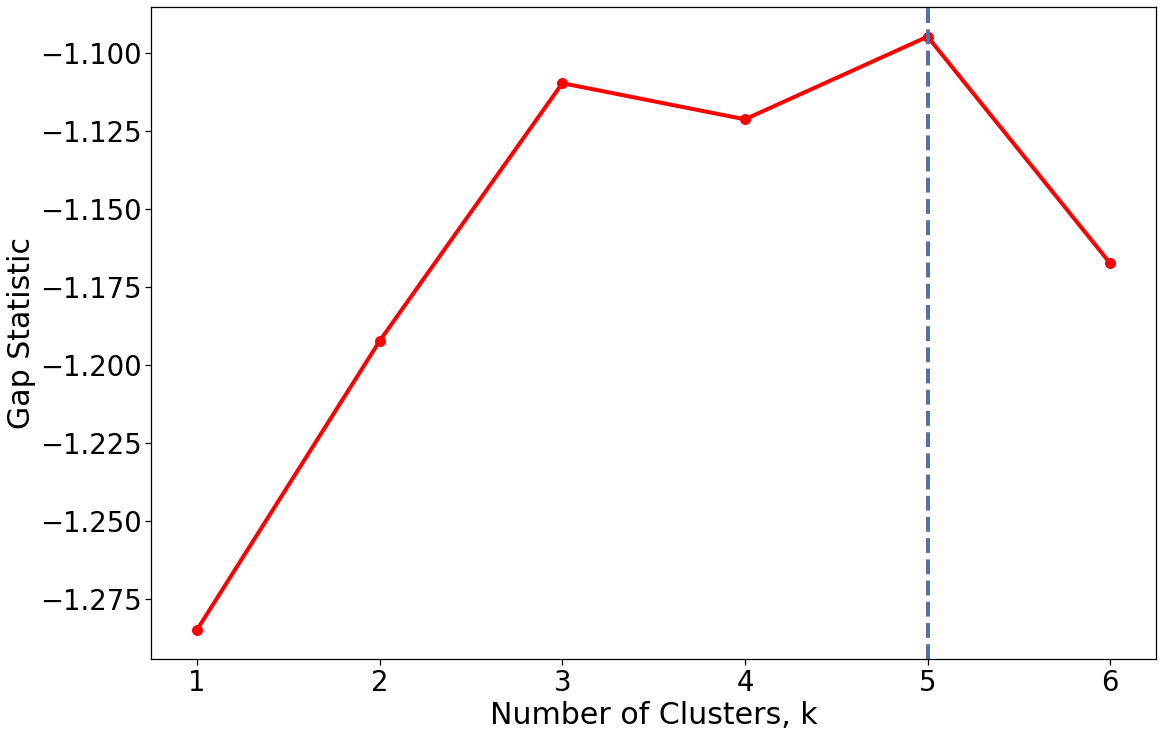

In [ ]:
# Gap Statistic

def optimalK(data, nrefs=3, maxClusters=15):
    """
    Calculates KMeans optimal K using Gap Statistic 
    Params:
        data: ndarry of shape (n_samples, n_features)
        nrefs: number of sample reference datasets to create
        maxClusters: Maximum number of clusters to test for
    Returns: (gaps, optimalK)
    """
    gaps = np.zeros((len(range(1, maxClusters)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
    for gap_index, k in enumerate(range(1, maxClusters)):
    # Holder for reference dispersion results
            refDisps = np.zeros(nrefs)
    # For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
            for i in range(nrefs):
                
                # Create new random reference set
                randomReference = np.random.random_sample(size=data.shape)
                
                # Fit to it
                centroids_Kmed, labels_Kmed, loss_Kmed = Kmedian(randomReference, k,
                                                                 random_state=42
                                                                 ) 
                
                refDisp = loss_Kmed
                refDisps[i] = refDisp
    # Fit cluster to original data and create dispersion

            centroids_Kmed, labels_Kmed, loss_Kmed = Kmedian(data, k, 
                                                             random_state=42
                                                             ) 
            
            origDisp = loss_Kmed
    # Calculate gap statistic
            gap = np.log(np.mean(refDisps)) - np.log(origDisp)
    # Assign this loop's gap statistic to gaps
            gaps[gap_index] = gap
            
            resultsdf = resultsdf.append({'clusterCount':k, 'gap':gap}, ignore_index=True)
    return (gaps.argmax() + 1, resultsdf)


score_g, df = optimalK(df_trans, nrefs=5, maxClusters=7)
plot_figures(df['clusterCount'], df['gap'], 'Gap Statistic')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

/usr

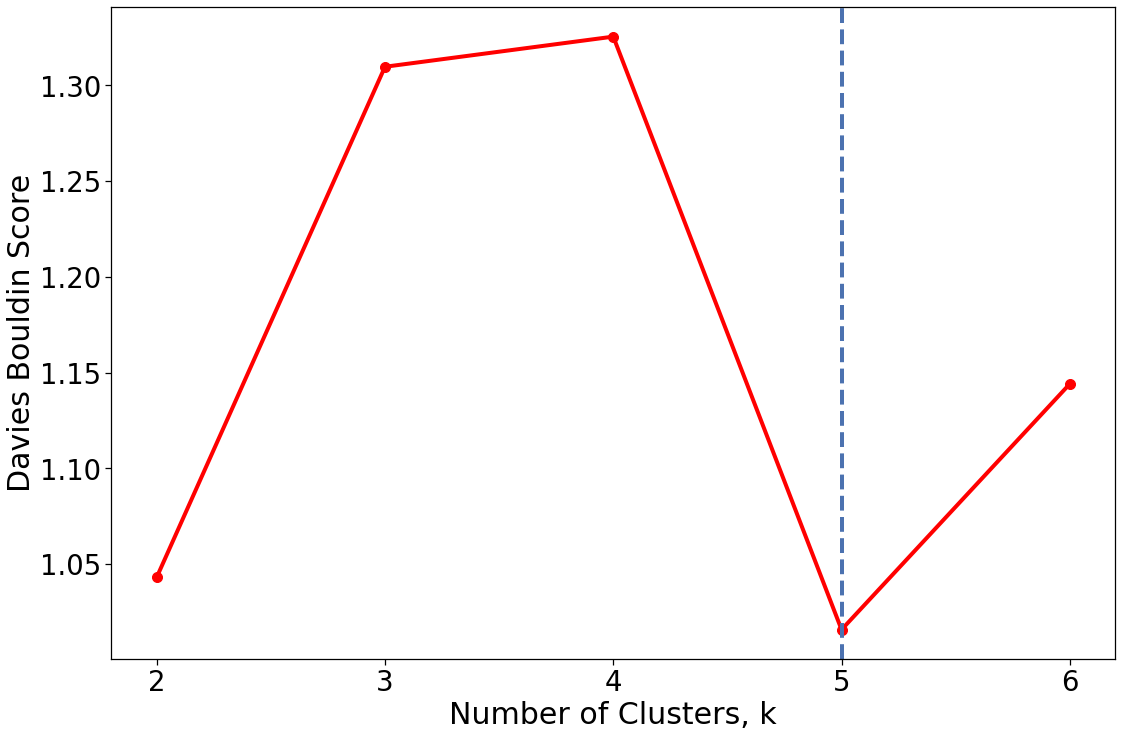

In [ ]:
# Davies Bouldin Score
ks = range(2, 7)
db = []
for k in ks:
    # Create a KMedian instance with k clusters: model
    centroids_Kmed, labels_Kmed, loss_Kmed = Kmedian(df_trans, k, random_state=42) 

        
    # Append the inertia to the list of inertias
    db.append(davies_bouldin_score(df_trans, labels_Kmed))
    
plot_figures(ks, db, 'Davies Bouldin Score')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



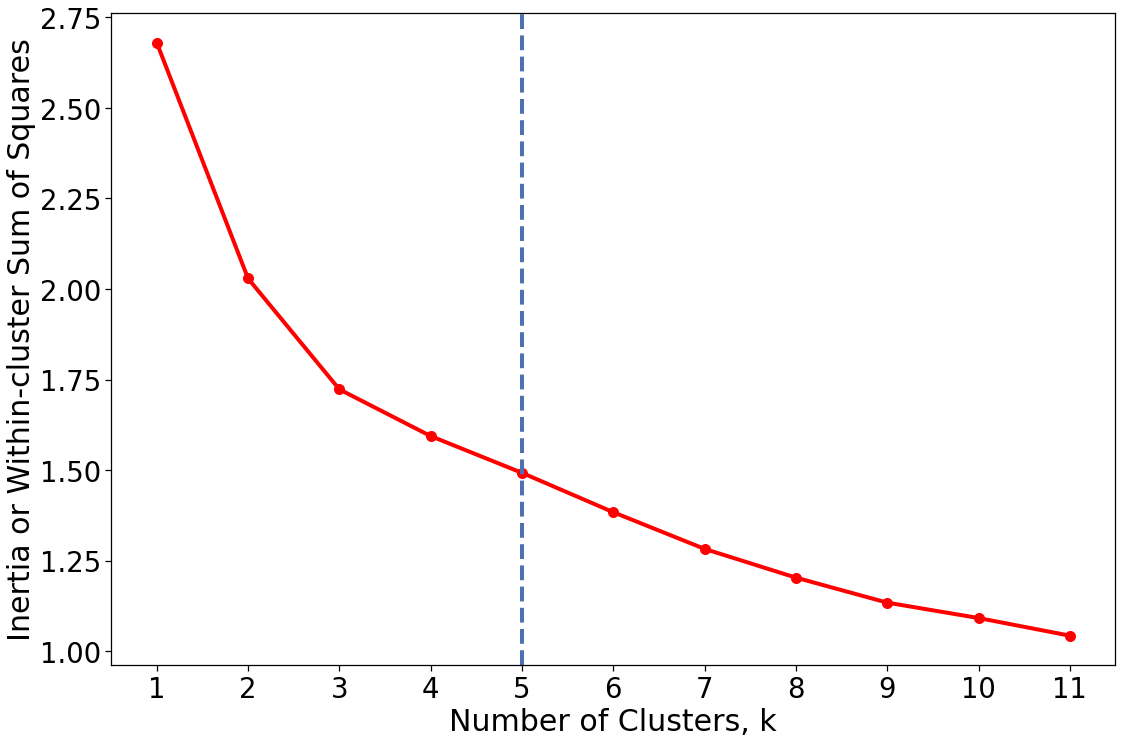

In [ ]:
# Elbow Method

ks = range(1, 12)
inertias1 = []
for k in ks:
    # Create a KMedians instance with k clusters: model
    centroids_Kmed, labels_Kmed, loss_Kmed = Kmedian(df_trans, k) 
    
    
    # Append the inertia to the list of inertias
    inertias1.append(loss_Kmed)

plot_figures(ks, inertias1, 'Inertia or Within-cluster Sum of Squares')

### Implementation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



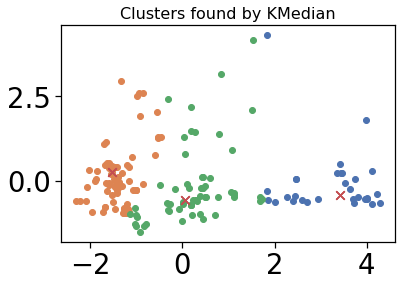

Silhouette score is 0.33090645623299075
Calinski Harabasz score is 112.82196568947258
Davies Bouldin score is 1.2850056423339684


In [ ]:
# Implementation of K-median

centroids_Kmed, labels_Kmed, loss_Kmed = Kmedian(df_trans, 3)  

clusters = np.unique(labels_Kmed)
# create scatter plot for samples from each cluster
for cluster in clusters:
  # get row indexes for samples with this cluster
  row_ix = np.where(labels_Kmed == cluster)
  # create scatter of these samples
  pyplot.scatter(df_trans[row_ix, 0], df_trans[row_ix, 1])
  plt.scatter(centroids_Kmed[:, 0], centroids_Kmed[:, 1], marker="x", s=70, linewidths=3,
            color="r", zorder=10)
  # show the plot
pyplot.title('Clusters found by KMedian', fontsize=16)
pyplot.show()

print('Silhouette score is', metrics.silhouette_score(df_trans, labels_Kmed, metric='manhattan'))
print('Calinski Harabasz score is', metrics.calinski_harabasz_score(df_trans, labels_Kmed))
print('Davies Bouldin score is', davies_bouldin_score(df_trans, labels_Kmed))

## Hierarchical clustering (HCA)

Connectivity-based clustering (hierarchical clustering)

### Cluster determination in HCA

### Optimal Cluster Number Determination



Here the dendogram is plotted to determine how many clusters makes sense

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
# generate the linkage matrix
Z = linkage(df_trans, 'ward')

In [ ]:
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

# Determine cophenetic correlation. Closer to 1 the better
c, coph_dists = cophenet(Z, pdist(df_trans))
c

0.7190376902223388

In [ ]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)
    plt.figure(figsize=(10, 7))    
    ddata = dendrogram(*args, **kwargs)
    size = 16
    if not kwargs.get('no_plot', False):
         
        plt.xlabel("Number of points in node (or index of point if no parenthesis)", size = size)
        plt.ylabel("Distance between Clusters", size = size)
        plt.yticks(size = size)
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c,)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center',
                             size = size
                             )
        # if max_d:
        #     plt.axhline(y=max_d, c='k', linestyle='--')
    return ddata

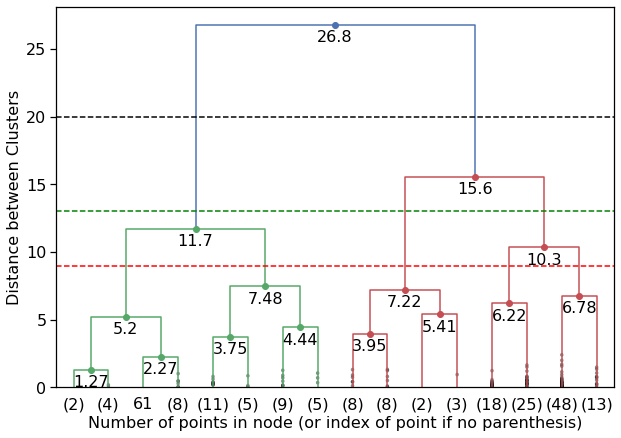

In [ ]:
fancy_dendrogram(
    Z,
    truncate_mode='level',
    p=3,
    # leaf_rotation=90.,
    leaf_font_size=16.,
    show_contracted=True,
    max_d =20,
    annotate_above=1,  # useful in small plots so annotations don't overlap to specify which distance to show in plot
)
plt.axhline(y=20, color='black', linestyle='--')
plt.axhline(y=13, color='green', linestyle='--')
plt.axhline(y=9, color='red', linestyle='--')



plt.show()

In [ ]:
# import scipy.cluster.hierarchy as shc

# plt.figure(figsize=(10, 7))  
# # plt.title("Dendrograms")  
# dend = shc.dendrogram(shc.linkage(df_trans, method='ward'), truncate_mode='level', p= 3)
# plt.ylabel("Distance", size = 15)
# plt.xlabel("Number of points in node (or index of point if no parenthesis)", size = 15)
# plt.axhline(y=10, color='black', linestyle='--')
# plt.yticks(size= 12)
# plt.xticks(size= 12)
# plt.show()

In [ ]:
Z[-6:,2]

array([ 7.21791746,  7.4759388 , 10.33496249, 11.70484157, 15.56557306,
       26.78476089])

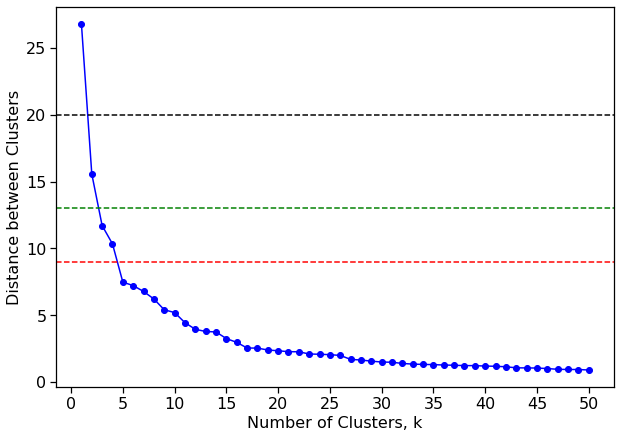

In [ ]:
HCA_Y = Z[-50:,2]
HCA_X = range(len(HCA_Y),0, -1)
plt.figure(figsize=(10, 7))  
size = 16
plt.plot(HCA_X, HCA_Y, '-o', color='blue')
plt.axhline(y=20, color='black', linestyle='--')
plt.axhline(y=13, color='green', linestyle='--')
plt.axhline(y=9, color='red', linestyle='--')

plt.xlabel('Number of Clusters, k', size= size)
plt.ylabel('Distance between Clusters', size= size)
plt.xticks(np.arange(0, max(HCA_X)+1, 5.0), size = size)
plt.yticks(size = size)
plt.show()

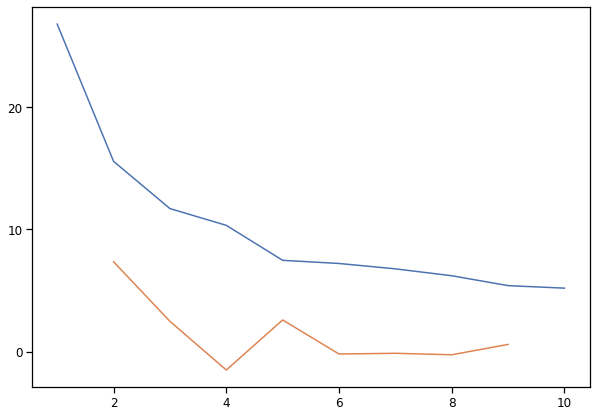

clusters: 2


In [ ]:
plt.figure(figsize=(10, 7)) 
last = Z[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.xticks(size = 12)
plt.yticks(size = 12)
plt.show()
k = acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
print ("clusters:", k)

We could implement 2 clusters or 5.

In [ ]:

from scipy.cluster.hierarchy import inconsistent

depth = 2
incons = inconsistent(Z, depth)
incons[-10:]

array([[ 2.91395225,  2.04147225,  3.        ,  1.12008923],
       [ 2.70248692,  2.54277004,  3.        ,  1.06348498],
       [ 3.90856947,  2.00931356,  3.        ,  1.14803718],
       [ 4.60442087,  1.90152993,  3.        ,  1.14335345],
       [ 5.52428453,  1.63800221,  3.        ,  1.03396255],
       [ 5.22300032,  1.98159574,  3.        ,  1.13693143],
       [ 7.7762801 ,  2.23370585,  3.        ,  1.14548762],
       [ 8.12712124,  3.30066247,  3.        ,  1.08394008],
       [11.03948434,  4.21818703,  3.        ,  1.07299385],
       [18.01839184,  7.83346868,  3.        ,  1.11909161]])

In [ ]:
from scipy.cluster.hierarchy import fcluster
max_d = 20
clusters = fcluster(Z, max_d, criterion='distance')
clusters

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1,
       2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 1, 2, 2, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1], dtype=int32)

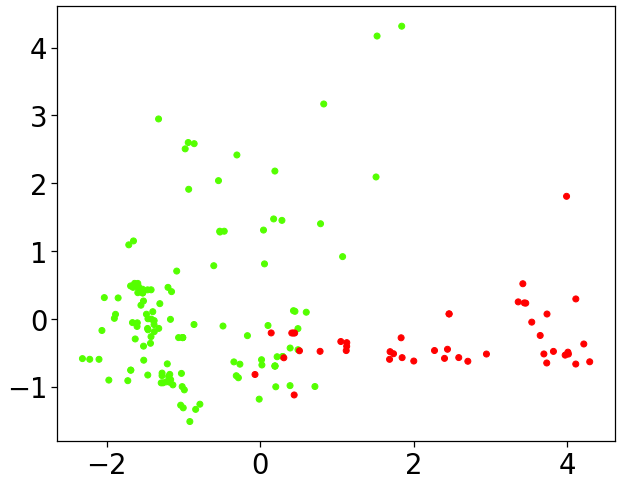

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(df_trans[:,0], df_trans[:,1], c=clusters, cmap='prism')  # plot points with cluster dependent colors
plt.show()



Using Silhouette Score method to select number of cluster

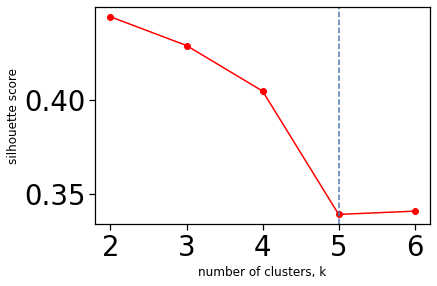

In [ ]:
# Silhouette Score method

ks = range(2, 7)
silhouette = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = cl.AgglomerativeClustering(n_clusters=k, )
    
    # Fit model to samples
    model.fit(df_trans)
        
    # Append the inertia to the list of inertias
    silhouette.append(silhouette_score(df_trans, model.labels_))
    
plt.plot(ks, silhouette, '-o', color='red')
plt.axvline(x=5, color='b', linestyle='--')
plt.xlabel('number of clusters, k',size = 12)
plt.ylabel('silhouette score',size = 12)
plt.xticks(ks)
plt.show()

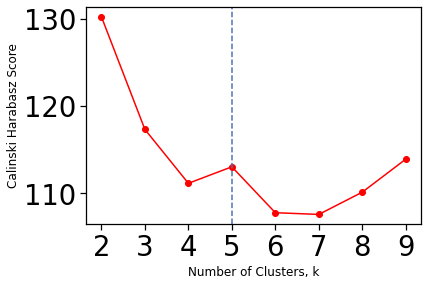

In [ ]:
# Calinski Harabasz Score
ks = range(2,10)
db = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = cl.AgglomerativeClustering(n_clusters=k, )
    
    # Fit model to samples
    model.fit(df_trans)
        
    # Append the inertia to the list of inertias
    # db.append(davies_bouldin_score(df_trans, model.labels_))
    db.append(metrics.calinski_harabasz_score(df_trans, model.labels_))
    
plt.plot(ks, db, '-o', color='red')
plt.axvline(x=5, color='b', linestyle='--')
plt.xlabel('Number of Clusters, k', size = 12)
plt.ylabel('Calinski Harabasz Score', size = 12)
plt.xticks(ks)
plt.show()

### Implementation

With PCA

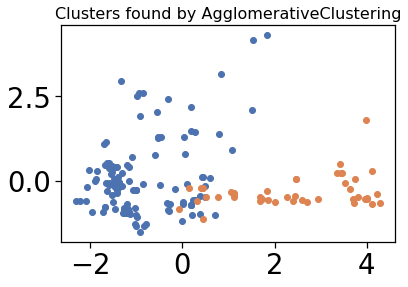

Silhouette score is 0.44422736977351845
Calinski Harabasz score is 130.25537513313157
Davies Bouldin score is 0.936214212891797


In [ ]:
plot_clusters(df_trans, cl.AgglomerativeClustering, (), {'n_clusters':2, 'linkage':'ward'})

## Comparison Outcome

K-Means outperforms HCA on almost all evaluation indices

# Cluster Exploration

A new data frame will be created that facilitates adding in the values of the separate components to the data set. The scores of the components are stored and labelled as Component 1, 2, 3 and so on. 
In addition, the labels from the Kmeans clustering will be stored in the new data frame.

In [ ]:
# Create new dataframe with original dataset and PCA components

df_clus = pd.concat([df_orig.reset_index(drop= True), pd.DataFrame(df_trans)], axis=1)
#Assign labels to components
df_clus.columns.values[-3:] = ['Principal Component 1', 'Principal Component 2',
                               'Principal Component 3',
                               ] 
df_clus["PCA_Cluster"] = kmeans_labels

df_clus.head()

,ID,Country,State,Latitude,Longitude,Operator,Field,Area,Formation,Depth,API,Temperature,Permeability,Sat_start,Pressure/MMP,Porosity,MMP,Pressure,Viscosity,Principal Component 1,Principal Component 2,Principal Component 3,PCA_Cluster
0,1,US,Wyo.,52.518045,-102.434766,Anadarko,Patrick Draw Monell,5800,Sandstone,5000,43.0,120,30.0,39.0,1.0,20.0,1200,1200,0.6,-0.784274,-1.260173,0.442184,1
1,2,US,Wyo.,53.490519,-103.133331,Anadarko,Salt Creek Southern Unit,570,Sandstone,1750,39.0,105,25.0,32.0,1.0,17.0,1200,1200,0.6,-1.970321,-0.904516,0.856782,1
2,3,US,Wyo.,52.818940,-103.366288,Anadarko,Salt Creek Southern Unit,1325,Sandstone,2200,39.0,112,30.0,32.0,1.0,18.0,1200,1200,0.6,-1.723211,-0.913188,0.873492,1
3,4,US,Wyo.,51.891222,-103.744590,Anadarko,Salt Creek,3500,Sandstone,1900,37.0,105,75.0,39.0,1.0,18.0,1200,1200,0.6,-1.684550,-0.757774,1.392157,1
4,5,US,Wyo.,52.285454,-102.707326,Anadarko,Salt Creek Ph 1-8,6000,Sandstone,1900,37.0,105,75.0,39.0,1.0,18.0,1200,1200,0.6,-1.684550,-0.757774,1.392157,1


In [ ]:
df_clus.groupby("PCA_Cluster").mean()

,ID,Latitude,Longitude,Area,Depth,API,Temperature,Permeability,Sat_start,Pressure/MMP,Porosity,MMP,Pressure,Viscosity,Principal Component 1,Principal Component 2,Principal Component 3
PCA_Cluster,,,,,,,,,,,,,,,,,
0,87.942857,44.774660,-96.855955,6059.114286,6820.000000,39.700000,145.285714,42.400000,53.693429,1.201190,13.994286,1171.685714,1407.400000,0.935836,0.480211,-0.520060,-0.407291
1,83.628205,44.754319,-93.888125,2859.179487,4636.358974,36.770513,103.076923,20.515385,47.626026,1.000000,12.756410,1235.897436,1235.897436,1.452611,-1.432138,-0.226933,-0.026684
2,114.176471,50.080461,-92.256686,3072.823529,5646.470588,37.911765,154.176471,1190.058824,39.046471,1.175315,23.705882,1558.000000,1769.176471,3.501930,1.059107,0.061927,1.793687
3,99.166667,47.483720,-84.214154,4487.277778,6089.166667,29.777778,137.777778,122.027778,50.715556,1.088022,9.936667,2797.444444,2984.111111,9.648355,-0.097283,2.147125,-0.362166
4,94.727273,45.002917,-87.788314,2946.590909,10436.363636,39.931818,229.818182,141.227273,45.246818,1.410529,20.609091,1877.363636,2481.409091,0.903341,3.574804,-0.172641,-0.347142


In [ ]:
df_clus.groupby("PCA_Cluster").count()

,ID,Country,State,Latitude,Longitude,Operator,Field,Area,Formation,Depth,API,Temperature,Permeability,Sat_start,Pressure/MMP,Porosity,MMP,Pressure,Viscosity,Principal Component 1,Principal Component 2,Principal Component 3
PCA_Cluster,,,,,,,,,,,,,,,,,,,,,,
0,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35
1,78,78,78,78,78,78,78,78,78,78,78,78,78,78,78,78,78,78,78,78,78,78
2,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17
3,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18
4,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22


In [ ]:
df_clus.groupby("PCA_Cluster").max()

,ID,Country,State,Latitude,Longitude,Operator,Field,Area,Formation,Depth,API,Temperature,Permeability,Sat_start,Pressure/MMP,Porosity,MMP,Pressure,Viscosity,Principal Component 1,Principal Component 2,Principal Component 3
PCA_Cluster,,,,,,,,,,,,,,,,,,,,,,
0,169,US,Wyo.,63.856225,-91.998685,Whiting Petroleum,Wertz,49900,Sandstone,9800,44.0,181,170.0,89.0,1.291667,22.0,1200,1550,2.000000,2.001576,0.118924,0.714838
1,162,US,Wyo.,54.530916,-73.709013,XTO Energy Inc.,West Welch,27848,Sandstone,6500,48.0,120,85.0,84.0,1.000000,25.0,4000,4000,5.497418,-0.784274,1.147647,2.080044
2,179,US,Wyo.,64.078682,21.679627,Vikor,West Heidelberg,14010,Sandstone,8500,42.0,190,4500.0,50.0,1.291667,37.0,4000,4350,20.016398,2.705766,3.167220,2.749419
3,178,US,Wyo.,63.177445,21.592354,Occidental,Weyburn Unit,30483,Sandstone,9000,40.0,248,1000.0,75.0,1.291667,16.3,4000,4500,92.000000,1.844478,4.314446,0.406742
4,170,US,Wyo.,63.881893,-80.157065,Texaco/MVP,West Mallalieu,12600,Sandstone,11950,45.0,260,770.0,64.0,2.000377,26.0,4000,5301,5.497418,4.293222,1.805667,0.840072


### Individual Cluster definition

In [ ]:
Cluster_1 = pd.DataFrame(df_clus.groupby("PCA_Cluster").get_group(0))
Cluster_2 = pd.DataFrame(df_clus.groupby("PCA_Cluster").get_group(1))
Cluster_3 = pd.DataFrame(df_clus.groupby("PCA_Cluster").get_group(2))
Cluster_4 = pd.DataFrame(df_clus.groupby("PCA_Cluster").get_group(3))
Cluster_5 = pd.DataFrame(df_clus.groupby("PCA_Cluster").get_group(4))



In [ ]:
print (Cluster_1.describe(exclude=np.number))
desc = Cluster_1.describe()
# desc.loc['count'] = desc.loc['count'].astype(int).astype(str)
# desc.iloc[1:] = desc.iloc[1:].applymap('{:.0f}'.format)
desc

       Country State          Operator   Field  Formation
count       35    35                35      35         35
unique       2     6                15      33          2
top         US  Tex.  Chaparral Energy  Postle  Sandstone
freq        34    17                 5       2         21


,ID,Latitude,Longitude,Area,Depth,API,Temperature,Permeability,Sat_start,Pressure/MMP,Porosity,MMP,Pressure,Viscosity,Principal Component 1,Principal Component 2,Principal Component 3,PCA_Cluster
count,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.00000,35.000000,35.000000,35.000000,35.000000,35.0
mean,87.942857,44.774660,-96.855955,6059.114286,6820.000000,39.700000,145.285714,42.400000,53.693429,1.201190,13.994286,1171.685714,1407.40000,0.935836,0.480211,-0.520060,-0.407291,0.0
std,53.804626,4.807624,5.020768,9321.684794,1209.861441,2.643527,17.788912,38.892159,15.181721,0.068156,4.090875,167.509573,223.87394,0.373667,0.639802,0.315101,0.477860,0.0
min,10.000000,40.777727,-112.423161,20.000000,5000.000000,35.000000,120.000000,4.000000,35.000000,1.000000,4.000000,209.000000,209.00000,0.390000,-0.483390,-1.185435,-1.324202,0.0
25%,24.500000,41.441467,-96.253453,1302.500000,6200.000000,38.250000,129.500000,13.500000,44.500000,1.166667,10.950000,1200.000000,1400.00000,0.688293,0.063096,-0.688840,-0.823327,0.0
50%,98.000000,43.668231,-95.608511,2500.000000,6400.000000,40.000000,145.000000,31.000000,48.030000,1.166667,14.000000,1200.000000,1400.00000,1.000000,0.389939,-0.557020,-0.316129,0.0
75%,138.000000,44.963051,-93.046423,7362.000000,7400.000000,41.000000,152.000000,52.500000,58.500000,1.291667,16.000000,1200.000000,1550.00000,1.000000,0.747609,-0.379293,-0.173433,0.0
max,169.000000,63.856225,-91.998685,49900.000000,9800.000000,44.000000,181.000000,170.000000,89.000000,1.291667,22.000000,1200.000000,1550.00000,2.000000,2.001576,0.118924,0.714838,0.0


In [ ]:
print (Cluster_2.describe(exclude=np.number))
desc = Cluster_2.describe()
desc.loc['count'] = desc.loc['count'].astype(int).astype(str)
desc.iloc[1:] = desc.iloc[1:].applymap('{:.2f}'.format)
desc


       Country State    Operator     Field   Formation
count       78    78          78        78          78
unique       1     6          20        71           2
top         US  Tex.  Occidental  Dover 35  Carbonates
freq        78    53          24         2          65


,ID,Latitude,Longitude,Area,Depth,API,Temperature,Permeability,Sat_start,Pressure/MMP,Porosity,MMP,Pressure,Viscosity,Principal Component 1,Principal Component 2,Principal Component 3,PCA_Cluster
count,78,78,78,78,78,78,78,78,78,78,78,78,78,78,78,78,78,78
mean,83.63,44.75,-93.89,2859.18,4636.36,36.77,103.08,20.52,47.63,1.00,12.76,1235.90,1235.90,1.45,-1.43,-0.23,-0.03,1.00
std,48.96,5.04,6.63,4767.17,1115.33,4.21,6.55,23.14,11.98,0.00,5.05,317.04,317.04,1.04,0.33,0.61,0.60,0.00
min,1.00,40.28,-103.74,5.00,1150.00,31.00,80.00,1.50,26.50,1.00,3.00,1200.00,1200.00,0.40,-2.31,-1.52,-0.85,1.00
25%,40.25,41.44,-96.00,296.25,4500.00,33.12,101.00,4.00,40.00,1.00,10.00,1200.00,1200.00,0.73,-1.61,-0.80,-0.49,1.00
50%,88.50,41.89,-95.46,1127.50,4950.00,35.00,104.00,6.00,48.03,1.00,11.70,1200.00,1200.00,1.00,-1.46,-0.15,-0.29,1.00
75%,124.75,49.46,-94.74,3575.00,5375.00,40.75,105.00,32.00,51.00,1.00,16.67,1200.00,1200.00,1.98,-1.18,0.31,0.32,1.00
max,162.00,54.53,-73.71,27848.00,6500.00,48.00,120.00,85.00,84.00,1.00,25.00,4000.00,4000.00,5.50,-0.78,1.15,2.08,1.00


In [ ]:
Cluster_2

,ID,Country,State,Latitude,Longitude,Operator,Field,Area,Formation,Depth,API,Temperature,Permeability,Sat_start,Pressure/MMP,Porosity,MMP,Pressure,Viscosity,Principal Component 1,Principal Component 2,Principal Component 3,PCA_Cluster
0,1,US,Wyo.,52.518045,-102.434766,Anadarko,Patrick Draw Monell,5800,Sandstone,5000,43.0,120,30.0,39.00,1.0,20.0,1200,1200,0.600000,-0.784274,-1.260173,0.442184,1
1,2,US,Wyo.,53.490519,-103.133331,Anadarko,Salt Creek Southern Unit,570,Sandstone,1750,39.0,105,25.0,32.00,1.0,17.0,1200,1200,0.600000,-1.970321,-0.904516,0.856782,1
2,3,US,Wyo.,52.818940,-103.366288,Anadarko,Salt Creek Southern Unit,1325,Sandstone,2200,39.0,112,30.0,32.00,1.0,18.0,1200,1200,0.600000,-1.723211,-0.913188,0.873492,1
3,4,US,Wyo.,51.891222,-103.744590,Anadarko,Salt Creek,3500,Sandstone,1900,37.0,105,75.0,39.00,1.0,18.0,1200,1200,0.600000,-1.684550,-0.757774,1.392157,1
4,5,US,Wyo.,52.285454,-102.707326,Anadarko,Salt Creek Ph 1-8,6000,Sandstone,1900,37.0,105,75.0,39.00,1.0,18.0,1200,1200,0.600000,-1.684550,-0.757774,1.392157,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,155,US,Tex.,41.588571,-95.519070,Whiting Petroleum,North Ward Estes,16300,Sandstone,2600,36.0,83,37.0,26.50,1.0,16.0,1200,1200,1.600000,-2.060297,-0.172791,0.856060,1
152,159,US,Tex.,42.129834,-96.127957,XTO Energy Inc.,Goldsmith,330,Carbonates,4200,35.0,105,32.0,48.03,1.0,11.6,1200,1200,4.313711,-1.710556,1.090098,0.326872,1
153,160,US,Tex.,42.388227,-95.080240,XTO Energy Inc.,Cordona Lake,2084,Carbonates,5500,40.0,101,4.0,48.03,1.0,22.0,1200,1200,4.313711,-1.199776,0.462890,0.567677,1
154,161,US,Tex.,41.377509,-95.736395,XTO Energy Inc.,Wasson (Cornell Unit),1923,Carbonates,4500,33.0,106,2.0,48.03,1.0,8.6,1200,1200,1.000000,-1.662412,-0.056548,-0.560807,1


In [ ]:
print (Cluster_3.describe(exclude=np.number))
desc = Cluster_3.describe()
desc.loc['count'] = desc.loc['count'].astype(int).astype(str)
desc.iloc[1:] = desc.iloc[1:].applymap('{:.2f}'.format)
desc



       Country State            Operator          Field  Formation
count       17    17                  17             17         17
unique       3     7                   6             14          1
top         US  Tex.  Denbury Resources   Jofrre Viking  Sandstone
freq        11     6                   7              4         17


,ID,Latitude,Longitude,Area,Depth,API,Temperature,Permeability,Sat_start,Pressure/MMP,Porosity,MMP,Pressure,Viscosity,Principal Component 1,Principal Component 2,Principal Component 3,PCA_Cluster
count,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17
mean,114.18,50.08,-92.26,3072.82,5646.47,37.91,154.18,1190.06,39.05,1.18,23.71,1558.00,1769.18,3.50,1.06,0.06,1.79,2.00
std,52.94,10.34,31.17,3877.17,1694.87,5.08,24.62,1370.54,8.51,0.13,8.39,808.51,733.94,6.25,1.04,1.03,0.56,0.00
min,51.00,40.26,-112.81,91.00,3000.00,22.00,108.00,110.00,24.00,0.82,13.00,1200.00,1200.00,0.50,-0.60,-1.12,1.17,2.00
25%,68.00,41.24,-111.44,480.00,4800.00,36.00,133.00,500.00,35.00,1.13,13.00,1200.00,1550.00,0.89,0.41,-0.57,1.29,2.00
50%,84.00,41.60,-95.48,1280.00,5075.00,38.00,152.00,500.00,38.00,1.17,24.00,1200.00,1550.00,1.14,0.79,-0.21,1.70,2.00
75%,171.00,62.64,-94.53,3900.00,6575.00,42.00,180.00,1500.00,48.03,1.29,30.00,1494.00,1694.00,2.00,1.84,0.07,2.09,2.00
max,179.00,64.08,21.68,14010.00,8500.00,42.00,190.00,4500.00,50.00,1.29,37.00,4000.00,4350.00,20.02,2.71,3.17,2.75,2.00


In [ ]:
print (Cluster_4.describe(exclude=np.number))
desc = Cluster_4.describe()
desc.loc['count'] = desc.loc['count'].astype(int).astype(str)
desc.iloc[1:] = desc.iloc[1:].applymap('{:.2f}'.format)
desc



       Country State    Operator        Field   Formation
count       18    18          18           18          18
unique       3     5          10           17           2
top         US  Tex.  Occidental  Nagylengyel  Carbonates
freq        14    10           5            2          14


,ID,Latitude,Longitude,Area,Depth,API,Temperature,Permeability,Sat_start,Pressure/MMP,Porosity,MMP,Pressure,Viscosity,Principal Component 1,Principal Component 2,Principal Component 3,PCA_Cluster
count,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18
mean,99.17,47.48,-84.21,4487.28,6089.17,29.78,137.78,122.03,50.72,1.09,9.94,2797.44,2984.11,9.65,-0.10,2.15,-0.36,3.00
std,51.02,8.21,38.43,7752.15,1317.27,5.50,46.44,319.78,8.35,0.09,4.15,997.90,980.86,21.43,0.92,0.96,0.51,0.00
min,8.00,40.42,-102.36,25.00,4300.00,16.00,97.00,2.00,35.00,1.00,1.06,1200.00,1400.00,0.83,-1.32,0.81,-1.28,3.00
25%,76.25,41.17,-100.28,462.50,5250.00,29.00,105.00,4.25,48.03,1.00,7.50,2350.00,2520.00,1.92,-0.78,1.34,-0.59,3.00
50%,99.50,42.11,-95.37,1271.50,5750.00,30.00,118.50,8.25,48.03,1.07,10.00,3000.00,3000.00,3.00,-0.38,2.06,-0.40,3.00
75%,124.50,53.68,-95.02,4050.25,6925.00,32.00,146.75,19.00,53.75,1.12,12.75,3750.00,3837.50,4.31,0.19,2.56,0.09,3.00
max,178.00,63.18,21.59,30483.00,9000.00,40.00,248.00,1000.00,75.00,1.29,16.30,4000.00,4500.00,92.00,1.84,4.31,0.41,3.00


In [ ]:
print (Cluster_5.describe(exclude=np.number))
desc = Cluster_5.describe()
desc.loc['count'] = desc.loc['count'].astype(int).astype(str)
desc.iloc[1:] = desc.iloc[1:].applymap('{:.2f}'.format)
desc



       Country  State            Operator    Field  Formation
count       22     22                  22       22         22
unique       2      4                   8       17          2
top         US  Miss.  Denbury Resources   Paradis  Sandstone
freq        19     13                  13        4         18


,ID,Latitude,Longitude,Area,Depth,API,Temperature,Permeability,Sat_start,Pressure/MMP,Porosity,MMP,Pressure,Viscosity,Principal Component 1,Principal Component 2,Principal Component 3,PCA_Cluster
count,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22
mean,94.73,45.00,-87.79,2946.59,10436.36,39.93,229.82,141.23,45.25,1.41,20.61,1877.36,2481.41,0.90,3.57,-0.17,-0.35,4.00
std,46.95,7.92,11.04,3760.60,1027.15,1.82,23.27,159.70,11.79,0.15,5.99,1163.74,1336.41,1.09,0.59,0.57,0.77,0.00
min,52.00,39.45,-112.27,44.00,8200.00,37.00,190.00,10.00,17.00,1.09,8.50,1200.00,1550.00,0.30,2.27,-0.67,-2.16,4.00
25%,59.25,41.02,-87.49,298.50,10150.00,39.00,207.50,55.50,41.00,1.42,17.00,1200.00,1700.00,0.43,3.43,-0.52,-0.63,4.00
50%,64.50,41.91,-81.76,1130.00,10525.00,40.00,238.00,90.00,46.00,1.42,23.20,1200.00,1700.00,0.65,3.71,-0.46,-0.31,4.00
75%,147.75,42.71,-81.26,3950.00,11075.00,40.75,250.00,168.75,52.00,1.42,26.00,2287.50,3687.50,0.74,4.00,0.19,-0.02,4.00
max,170.00,63.88,-80.16,12600.00,11950.00,45.00,260.00,770.00,64.00,2.00,26.00,4000.00,5301.00,5.50,4.29,1.81,0.84,4.00


In [ ]:
data_table.DataTable(Cluster_3)

,ID,Country,State,Latitude,Longitude,Operator,Field,Area,Formation,Depth,API,Temperature,Permeability,Sat_start,Pressure/MMP,Porosity,MMP,Pressure,Viscosity,Principal Component 1,Principal Component 2,Principal Component 3,PCA_Cluster
45,51,US,Mont.,56.431424,-105.648486,Denbury Resources,Bell Creek,2800,Sandstone,4500,36.0,108,1035.0,29.00,1.000000,24.0,1200,1200,20.016398,-0.603369,0.782262,2.522013,2
48,54,US,Wyo.,51.922971,-102.689040,Denbury Resources,Grieve,2280,Sandstone,6575,36.0,180,247.0,48.03,1.291667,20.0,1200,1550,0.730714,1.836728,-0.280599,1.171562,2
49,55,US,Tex.,40.868283,-94.530418,Denbury Resources,Hastings,4420,Sandstone,5800,36.0,165,1500.0,48.03,1.291667,30.0,1200,1550,0.730714,1.737972,-0.515776,2.091096,2
61,67,US,La.,40.257390,-87.442003,Denbury Resources,Delhi,14010,Sandstone,3500,42.0,135,2000.0,35.00,1.166667,30.0,1200,1400,0.756918,0.443652,-1.123810,2.742009,2
62,68,US,Tex.,41.602062,-95.481502,Denbury Resources,Oyster Bayou,3900,Sandstone,8500,39.5,190,2000.0,26.70,1.291667,28.0,1200,1550,0.894121,2.705766,-0.626909,1.372871,2
63,69,US,Miss.,41.059508,-80.660981,Denbury Resources,Tinsley,10104,Sandstone,4800,33.0,164,289.0,24.00,1.291667,23.0,1200,1550,2.787545,1.074640,0.916137,1.995213,2
64,70,US,Miss.,41.300385,-81.422810,Denbury Resources,West Heidelberg,2500,Sandstone,5000,22.0,152,300.0,37.00,1.087500,28.0,4000,4350,20.016398,0.828876,3.167220,2.627879,2
76,83,US,Tex.,41.355959,-95.456611,George R. Brown,Rose City North,800,Sandstone,8200,37.0,180,4500.0,50.00,1.291667,37.0,1200,1550,2.000000,2.461597,0.071306,1.717595,2
77,84,US,Tex.,40.779545,-95.177064,George R. Brown,Rose City South,900,Sandstone,8200,37.0,180,4500.0,50.00,1.291667,37.0,1200,1550,2.000000,2.461597,0.071306,1.717595,2
144,151,US,Tex.,41.401882,-96.589774,Texaco,Garden Island Bay,91,Sandstone,8000,36.0,190,500.0,48.00,1.291667,29.0,1200,1550,0.500000,2.587455,-0.572377,1.487104,2


## Geographic view

In [ ]:
# !pip install libgeos-3.5.0
# !pip install libgeos-dev
# !pip install https://github.com/matplotlib/basemap/archive/master.zip

In [ ]:
# pip install https://github.com/matplotlib/basemap/archive/master.zip

In [ ]:
# import matplotlib.pyplot as plt
# import matplotlib as mlt
# from mpl_toolkits.basemap import Basemap
# # from PIL import Image
# # from pylab import rcParams

In [ ]:
# df_viz = Cluster_3[['Latitude','Longitude']]

In [ ]:

# # Define upper and lower bounds of plot
# llat =-50
# ulat= 80

# llong=-140
# ulong=70

# print(len(df_viz))

In [ ]:
# fig = plt.gcf()
# fig.set_size_inches(25, 40)

# m = Basemap(projection='merc', 
#             llcrnrlon=llong, llcrnrlat=llat,urcrnrlon=ulong, urcrnrlat=ulat,

#             lat_ts=20, 
#             resolution='c')

# m.bluemarble(scale=0.2)   # full scale will be overkill
# m.drawcoastlines(color='white', linewidth=0.2)  # add coastlines

# x, y = m(np.asarray(df_viz.Longitude), np.asarray(df_viz.Latitude)) # transform coordinates
# plt.scatter(x, y, 100, marker='o', color='Red') 

# plt.show()

In [ ]:
# # Plotting map

# fig = plt.gcf()
# fig.set_size_inches(8, 7)

# my_map=Basemap(projection='merc',
#             resolution = 'l',
#             #  area_thresh = 1000.0,
#             lat_ts=20,
#             llcrnrlon=llong, llcrnrlat=llat,urcrnrlon=ulong, urcrnrlat=ulat)

# my_map.bluemarble(scale=0.2)   # full scale will be overkill
# my_map.drawcoastlines()
# my_map.drawcountries()
# my_map.drawlsmask(land_color='lightgrey', ocean_color='skyblue')
# xs,ys = my_map(np.asarray(df_viz.Longitude), np.asarray(df_viz.Latitude))



# # df_viz['x']= xs.tolist()
# # df_viz['y'] =ys.tolist()

# # for index,row in df_viz.iterrows():
# #    my_map.plot(row.x,row.y,markerfacecolor='green',
# #                markeredgecolor='white',marker='o',markersize=10)

# plt.scatter(xs, ys, 10, marker='o', color='Red') 

# plt.show()

In [ ]:
# # Load in the data
# filepath = '/content/Book3.csv'
# # country = pd.read_csv(filepath)
# country = Cluster_5

In [ ]:
# US = country[country.Country == 'US']

# temp = country[['ID', 'Country']].groupby(['ID', 'Country']).count()
# temp = temp.reset_index(drop = False)
# countries = temp['Country'].value_counts()
# print('Number of countries in the data set: {}'.format(len(countries)))

Results on choropleth map

In [ ]:
# fig = px.choropleth(locations=countries.index, locationmode="country names",
#                     color=countries, scope="world", width=2000, height = 800)
# fig.show()


In [ ]:
# temp = US[['ID', 'State']].groupby(['ID', 'State']).count()
# temp = temp.reset_index(drop = False)
# states = temp['State'].value_counts()
# states_u = temp['State'].unique()
# print('Number of states in the data set: {}'.format(len(states)))

In [ ]:

# fig = px.choropleth(locations=states.index, locationmode="USA-states",
#                     color=states,
#                     scope="usa") 

# fig.show()


## Other Clusters

## Data Visualization

### Scatterplot

We create a new column named ‘Cluster’ and map the clusters directly inside it.

In [ ]:
df_clus['Cluster'] =df_clus["PCA_Cluster"].map( {0: "Project Type 1",
                                                 1:"Project Type 2", 
                                                 2: "Project Type 3",
                                                 3:"Project Type 4", 
                                                 4: "Project Type 5",

                                                })

In [ ]:
# fig = px.scatter(data_frame=df_clus,
#                     x="Principal Component 1",
#                     y="Principal Component 2",
#                     color='Cluster',
#                     color_discrete_sequence=px.colors.qualitative.Plotly
                 
#                     )

# fig.show()



Looks like something that could be better defined with 3D!

In [ ]:
# fig = plt.figure(figsize= (10.2, 6.3))
# ax = fig.add_subplot(111, projection='3d')
# scatter = ax.scatter(centroids[:, 0],
#             centroids[:, 1],
#             centroids[:, 2],
#             s = 200,
#             marker='o',
#             c='red',
#             label='centroids')


# scatter = ax.scatter(df_clus["Principal Component 1"],
#                      df_clus["Principal Component 2"],
#                      df_clus["Principal Component 3"],
#                      c=df_clus['PCA_Cluster'],
#                      marker='^',
#                      s=80,                          
#                      cmap='Dark2'
#                      )


# ax.set_xlabel('Principal Component 1')
# ax.set_ylabel('Principal Component 2')
# ax.set_zlabel('Principal Component 3')
# ax.legend()
# plt.show()

In [ ]:
df_PC = df_clus [['Principal Component 1', 'Principal Component 2', 'Principal Component 3', 
                  ]]
df_cent = pd.DataFrame(centroids, columns=df_PC.columns)
cent_color = ['centroid','centroid','centroid',
              'centroid','centroid', 

]

In [ ]:
fig = px.scatter_3d(data_frame=df_cent,
                    x="Principal Component 1",
                    y="Principal Component 2",
                    z = 'Principal Component 3',
                    color= cent_color,
                    height =800,
                    color_discrete_sequence=px.colors.qualitative.Set1
                    )
fig.update_traces(marker=dict(size=5,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),marker_symbol= 'x',
                  selector=dict(mode='markers'))


for num in range(5):
  fig.add_trace(px.scatter_3d(data_frame=df_clus,
                      x="Principal Component 1",
                      y="Principal Component 2",
                      z = 'Principal Component 3',
                      color='Cluster',
                      height =800,
                      color_discrete_sequence=px.colors.qualitative.Bold
                      ).data[num])


fig.show()

In [ ]:
# Without clusters
fig = px.scatter_3d(data_frame=df_clus,
                    x="Principal Component 1",
                    y="Principal Component 2",
                    z = 'Principal Component 3',
                    height =800,
                    color_discrete_sequence=px.colors.qualitative.Bold
                    )

fig.show()

In [ ]:
df_PC = df_clus [['Principal Component 1', 'Principal Component 2', 'Principal Component 3', 
                 ]]

# project = np.array([[ 1.57744636, -0.79423105,  1.05706574],
#        [ 0.91118426, -0.17930478, -0.90424289],
#        [ 3.8748043 , -0.77264129, -0.94714234]])
# df_project = pd.DataFrame(projects, columns=df_PC.columns)

# project = ['project','project','project']



project1 = np.array([[ 1.57744636, -0.79423105,  1.05706574],
])
df_project1 = pd.DataFrame(project1, columns=df_PC.columns)

project1 = ['Hansford Marmaton Field Project']

project2 = np.array([
       [ 0.91118426, -0.17930478, -0.90424289],
     ])
df_project2 = pd.DataFrame(project2, columns=df_PC.columns)

project2 = ['Weyburn Field Project']

project3 = np.array([
       [ 3.8748043 , -0.77264129, -0.94714234]])
df_project3 = pd.DataFrame(project3, columns=df_PC.columns)

project3 = ['Paradis Field Project']


In [ ]:
height = 700

fig = px.scatter_3d(data_frame=df_project1,
                    x="Principal Component 1",
                    y="Principal Component 2",
                    z = 'Principal Component 3',
                    color= project1,
                    height =height,
                    color_discrete_sequence=['goldenrod']
                    )
fig.update_traces(marker=dict(size=9),marker_symbol= 'diamond',
                  selector=dict(mode='markers'))

for num in range(1):
  fig.add_trace(px.scatter_3d(data_frame=df_project2,
                      x="Principal Component 1",
                      y="Principal Component 2",
                      z = 'Principal Component 3',
                      color= project2,
                      height =height,
                      # color_discrete_sequence=px.colors.qualitative.Set1
                      color_discrete_sequence=["blue"],
                      ).data[num])
  fig.update_traces(marker=dict(size=9),marker_symbol= 'diamond',
                      selector=dict(mode='markers'))
for num in range(1):
  fig.add_trace(px.scatter_3d(data_frame=df_project3,
                      x="Principal Component 1",
                      y="Principal Component 2",
                      z = 'Principal Component 3',
                      color= project3,
                      height =height,
                      color_discrete_sequence=["deeppink"]
                      ).data[num])
  fig.update_traces(marker=dict(size=9),marker_symbol= 'diamond',
                    selector=dict(mode='markers'))


for num in range(5):
  fig.add_trace(px.scatter_3d(data_frame=df_clus,
                      x="Principal Component 1",
                      y="Principal Component 2",
                      z = 'Principal Component 3',
                      color='Cluster',
                      height =height,
                      color_discrete_sequence=px.colors.qualitative.Bold
                      ).data[num])


fig.show()

Next the clusters are visualized relative to the field features to determine the reservoir, fluid, and field properties that are criteria for cluster membership.

In [ ]:
df_clus.describe()

,ID,Latitude,Longitude,Area,Depth,API,Temperature,Permeability,Sat_start,Pressure/MMP,Porosity,MMP,Pressure,Viscosity,Principal Component 1,Principal Component 2,Principal Component 3,PCA_Cluster
count,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,1.700000e+02,1.700000e+02,1.700000e+02,170.000000
mean,90.652941,45.612288,-92.522315,3723.052941,6091.358824,37.156471,136.952941,168.345294,48.036471,1.121400,14.823882,1503.241176,1670.823529,2.347851,-2.987806e-17,1.208184e-16,3.918434e-18,1.494118
std,50.652344,6.622341,17.200088,6222.498067,2236.837940,4.865406,46.058852,557.263792,12.627600,0.160353,6.692277,796.527445,893.009097,7.578300,1.769589e+00,9.996885e-01,8.540177e-01,1.288305
min,1.000000,39.448742,-112.812513,5.000000,1150.000000,16.000000,80.000000,1.500000,17.000000,0.815710,1.060000,209.000000,209.000000,0.300000,-2.314144e+00,-1.515635e+00,-2.155937e+00,0.000000
25%,48.250000,41.375708,-96.234880,468.750000,4900.000000,34.000000,104.000000,5.000000,39.250000,1.000000,10.000000,1200.000000,1200.000000,0.730714,-1.419145e+00,-6.203733e-01,-5.024121e-01,1.000000
50%,91.500000,41.985512,-95.326680,1325.000000,5500.000000,38.000000,114.000000,29.000000,48.030000,1.000000,13.000000,1200.000000,1400.000000,1.000000,-5.338940e-01,-2.479192e-01,-2.603498e-01,1.000000
75%,133.750000,49.553542,-92.736030,4413.000000,6950.000000,41.000000,152.000000,69.250000,52.000000,1.166667,18.075000,1200.000000,1658.000000,1.907694,7.644041e-01,3.635997e-01,3.673253e-01,2.000000
max,179.000000,64.078682,21.679627,49900.000000,11950.000000,48.000000,260.000000,4500.000000,89.000000,2.000377,37.000000,4000.000000,5301.000000,92.000000,4.293222e+00,4.314446e+00,2.749419e+00,4.000000


### Boxplot 

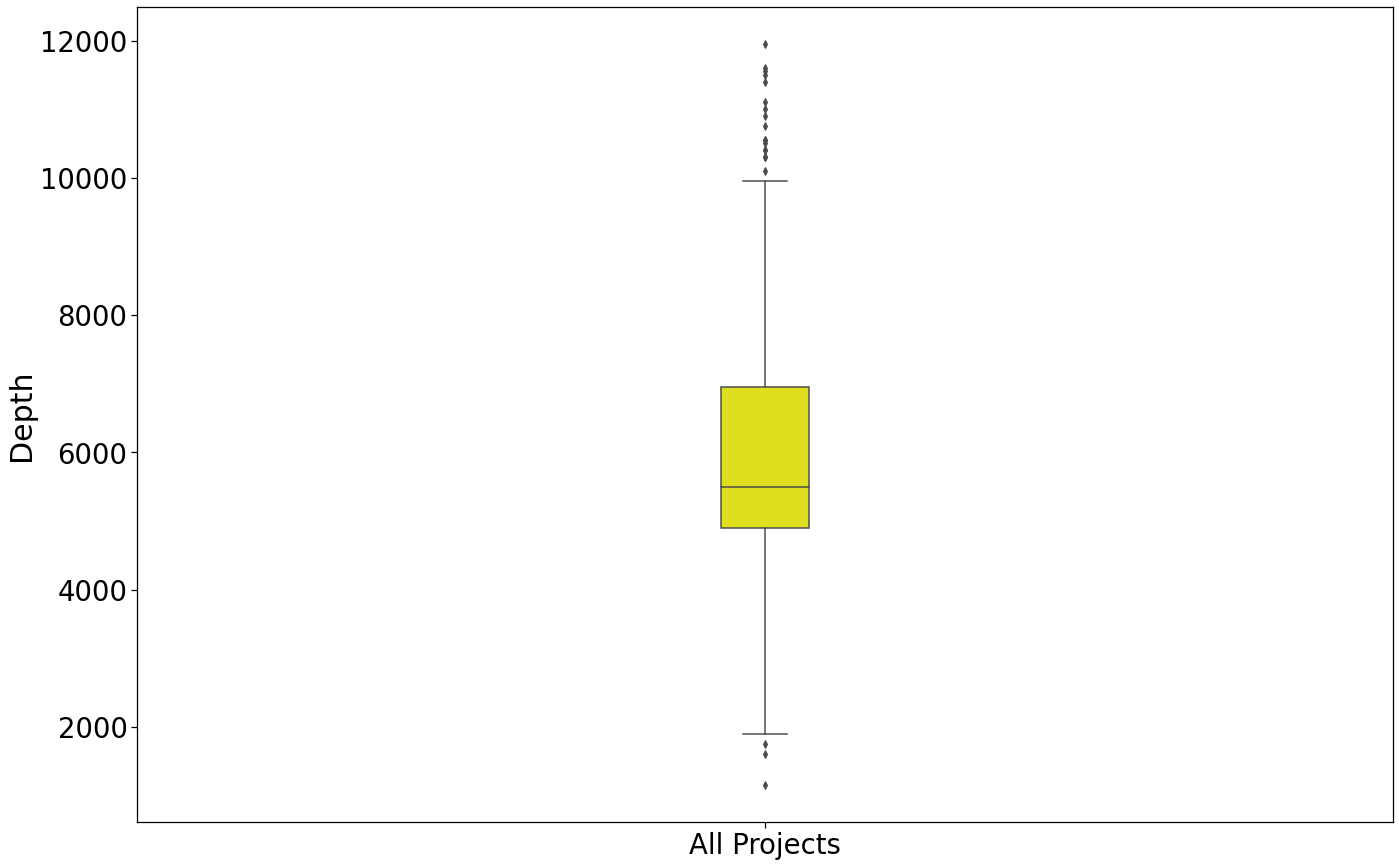

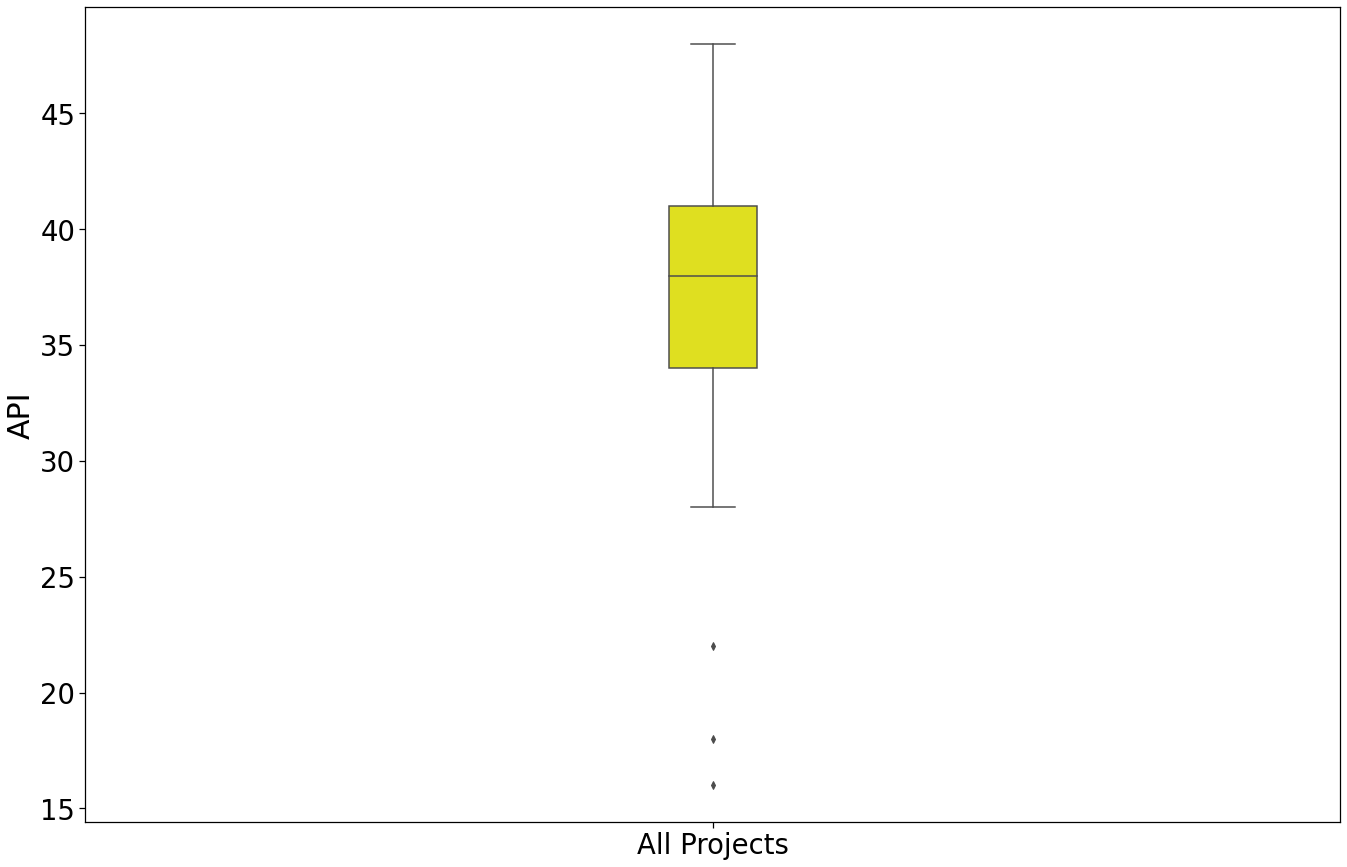

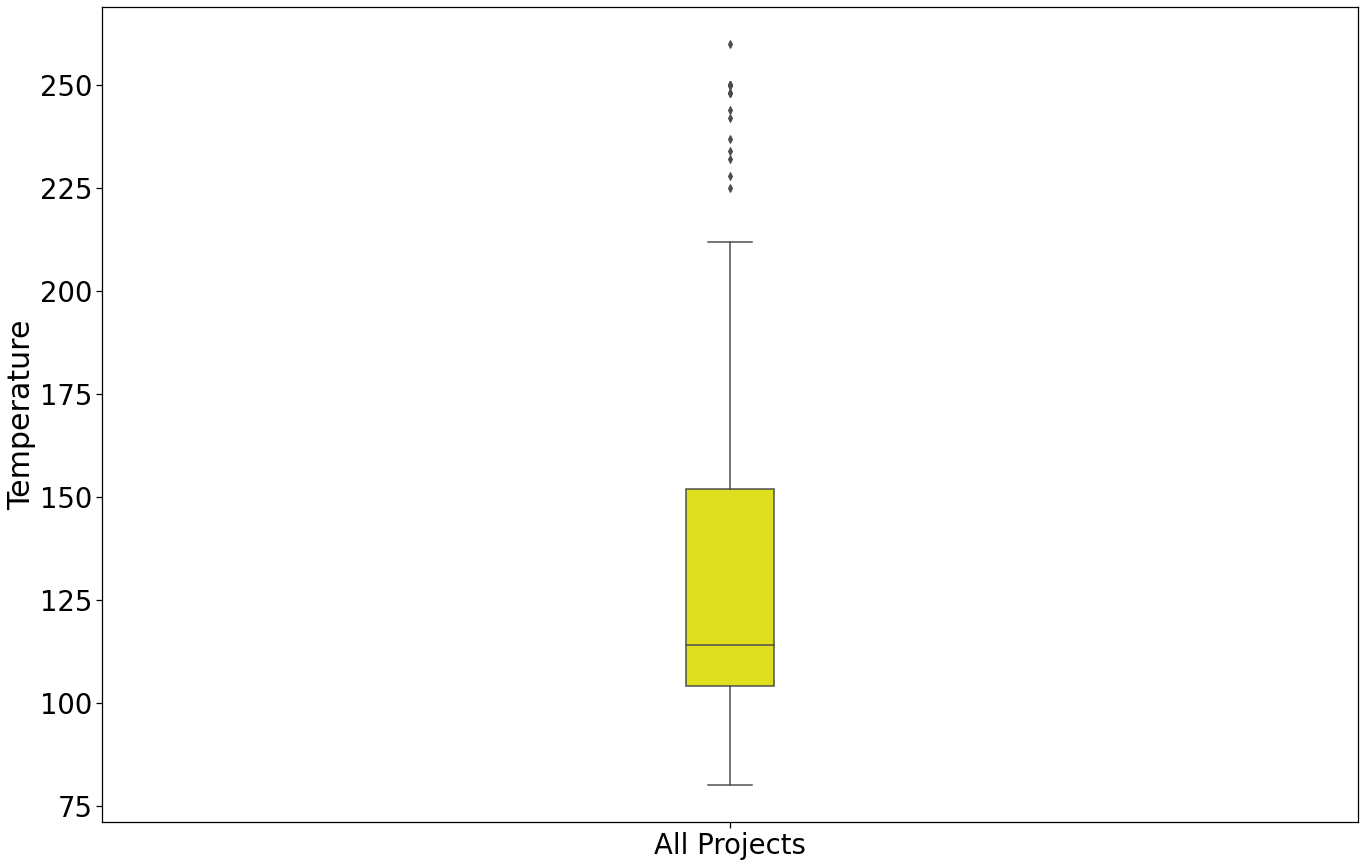

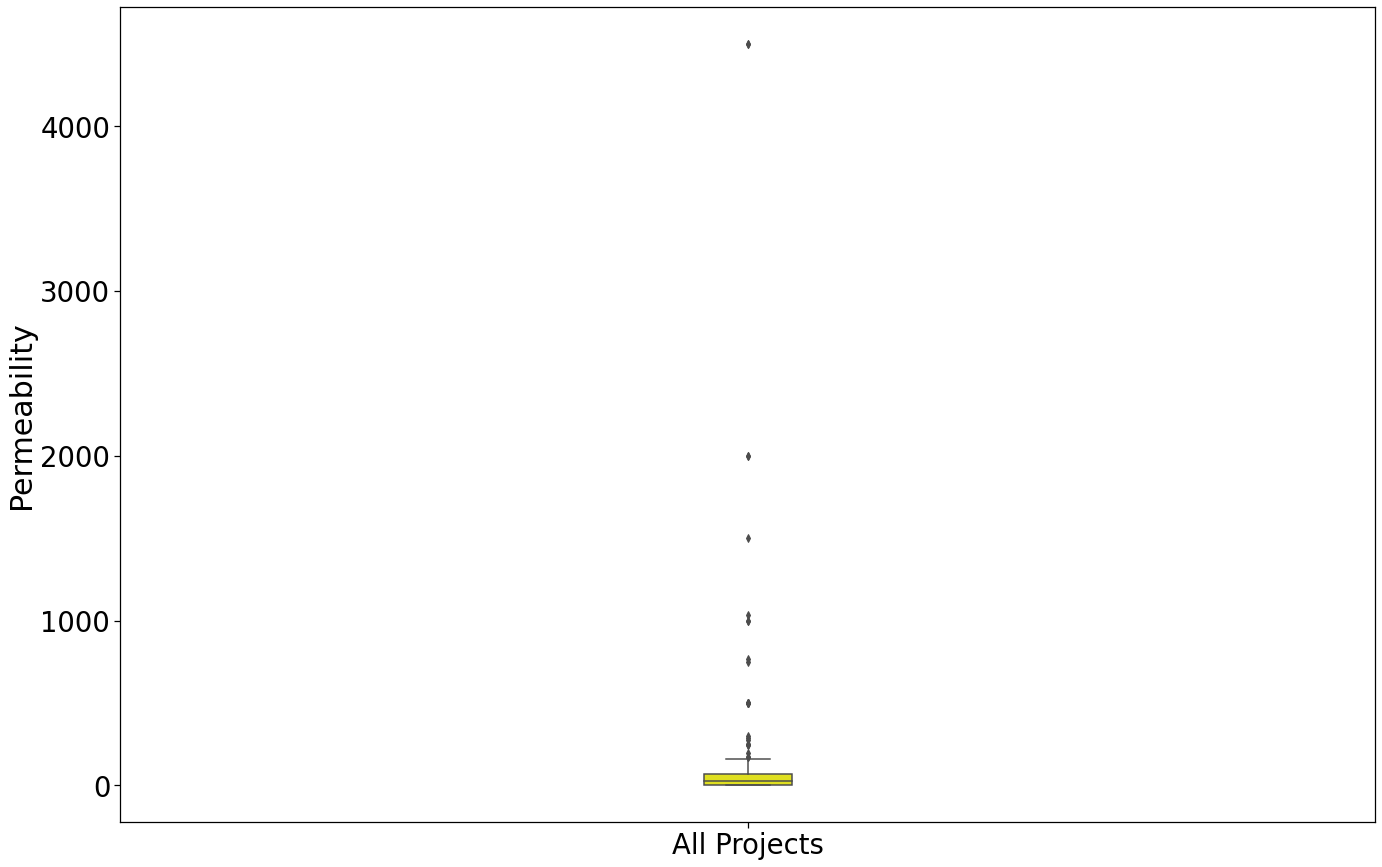

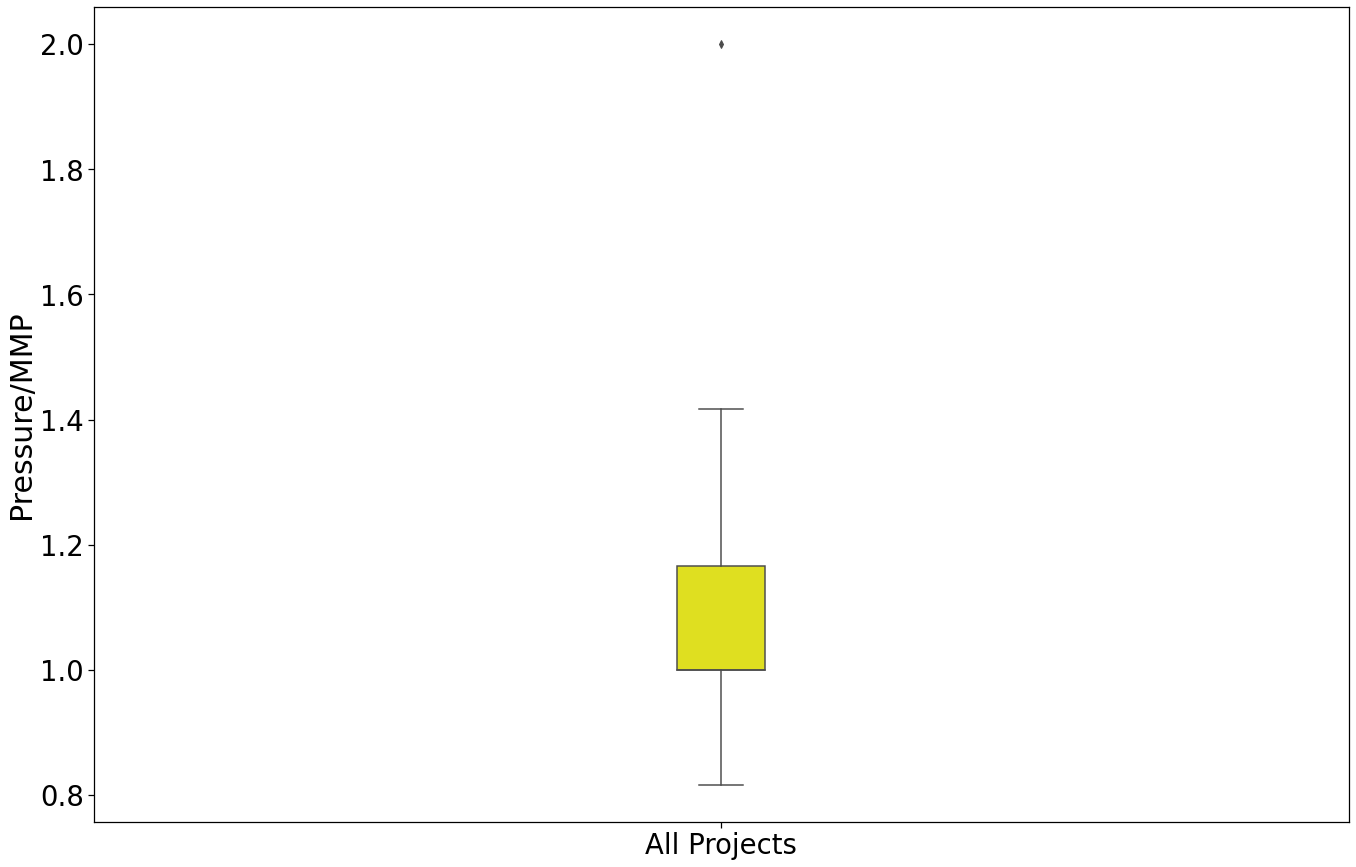

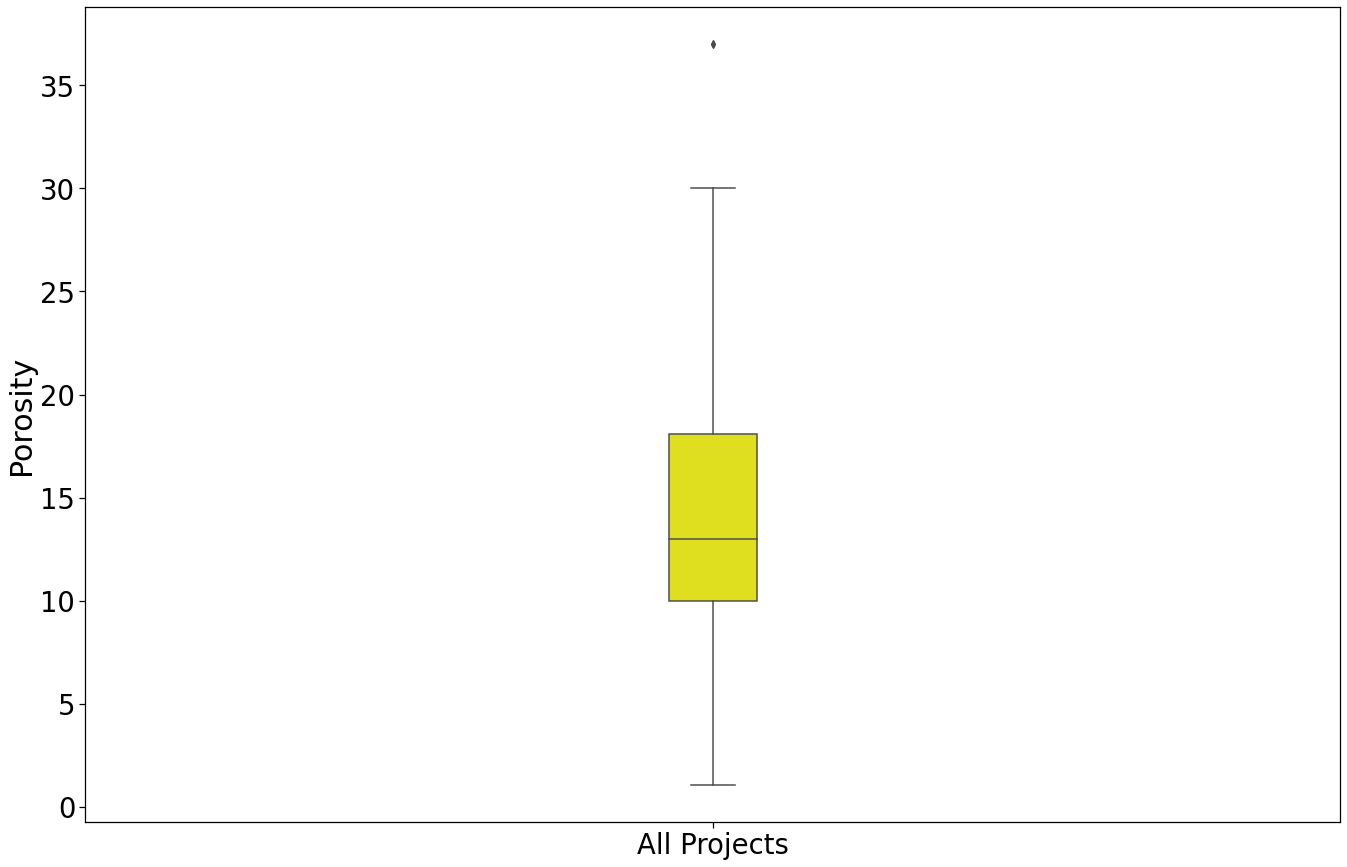

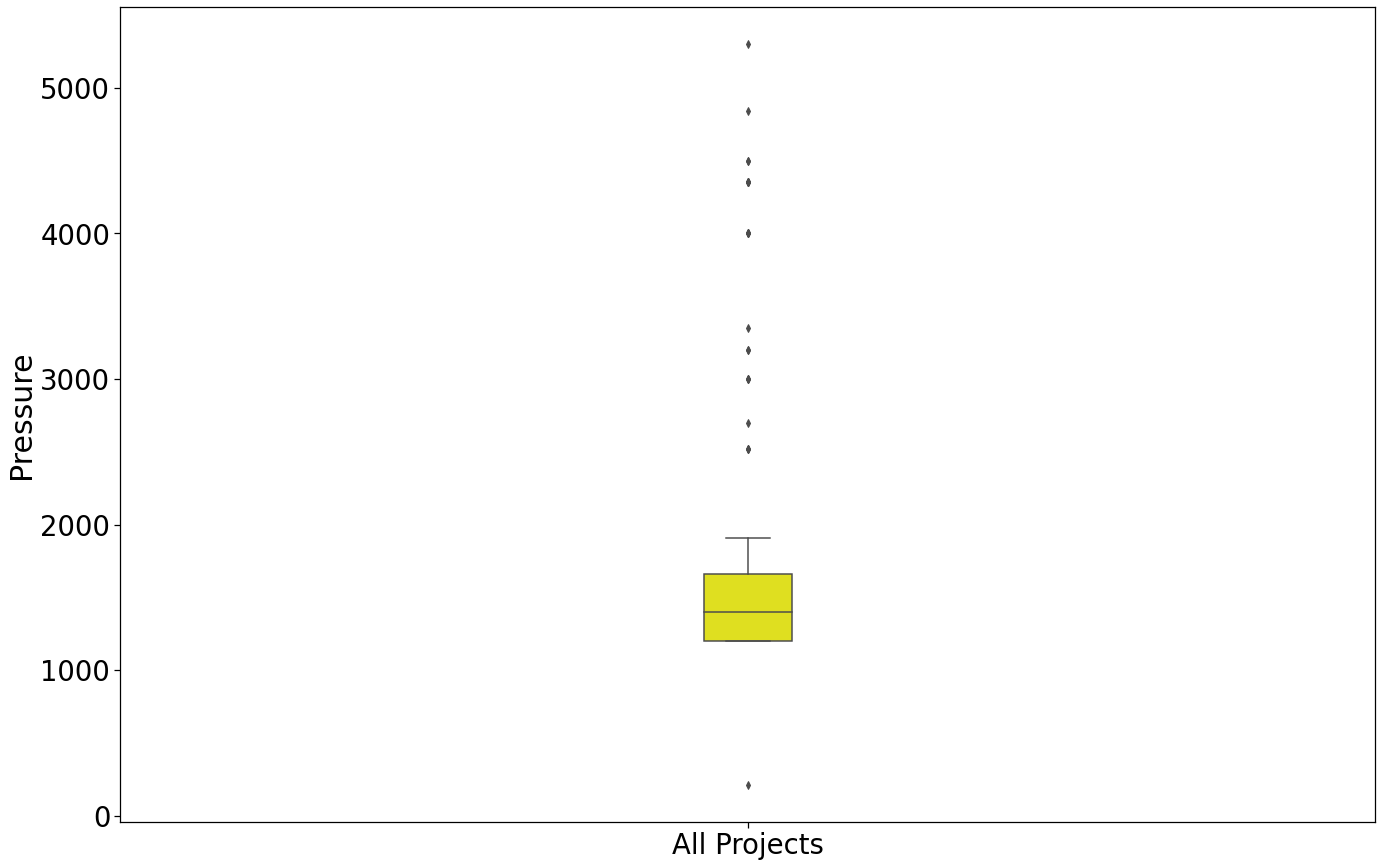

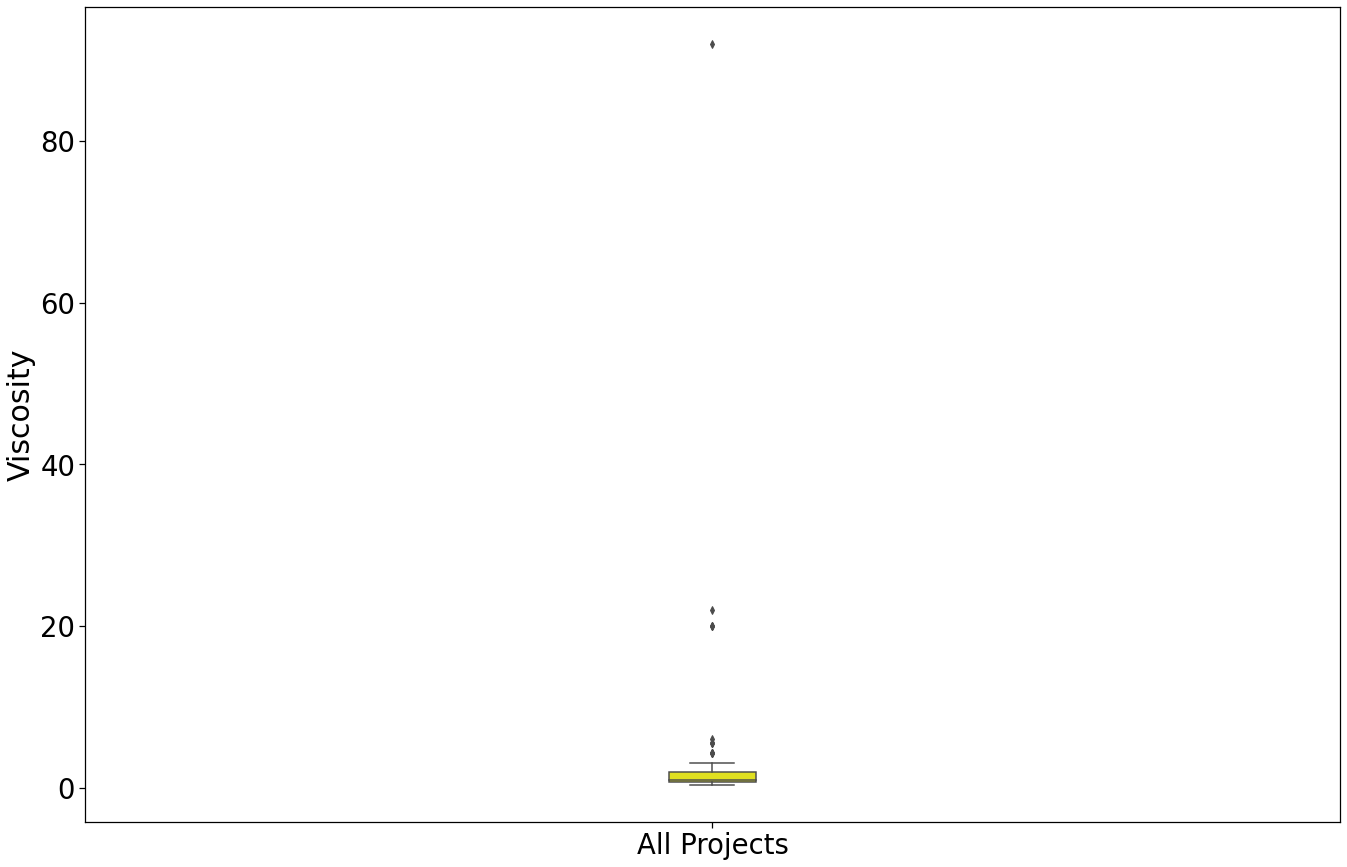

In [ ]:

Columns = ['PCA_Cluster', 'Depth',	'API',	'Temperature',	'Permeability',	'Pressure/MMP',	'Porosity',	'Pressure',	'Viscosity']

df_im = df_clus[Columns]


column = df_im.drop('PCA_Cluster',axis=1).columns

for col in column:
 
  plt.figure(figsize=(22.5,15))
  sns.boxplot(data=df_im, y=col, width= 0.07, color= 'yellow', )

  plt.xticks([0], ['All Projects'])
  plt.show()


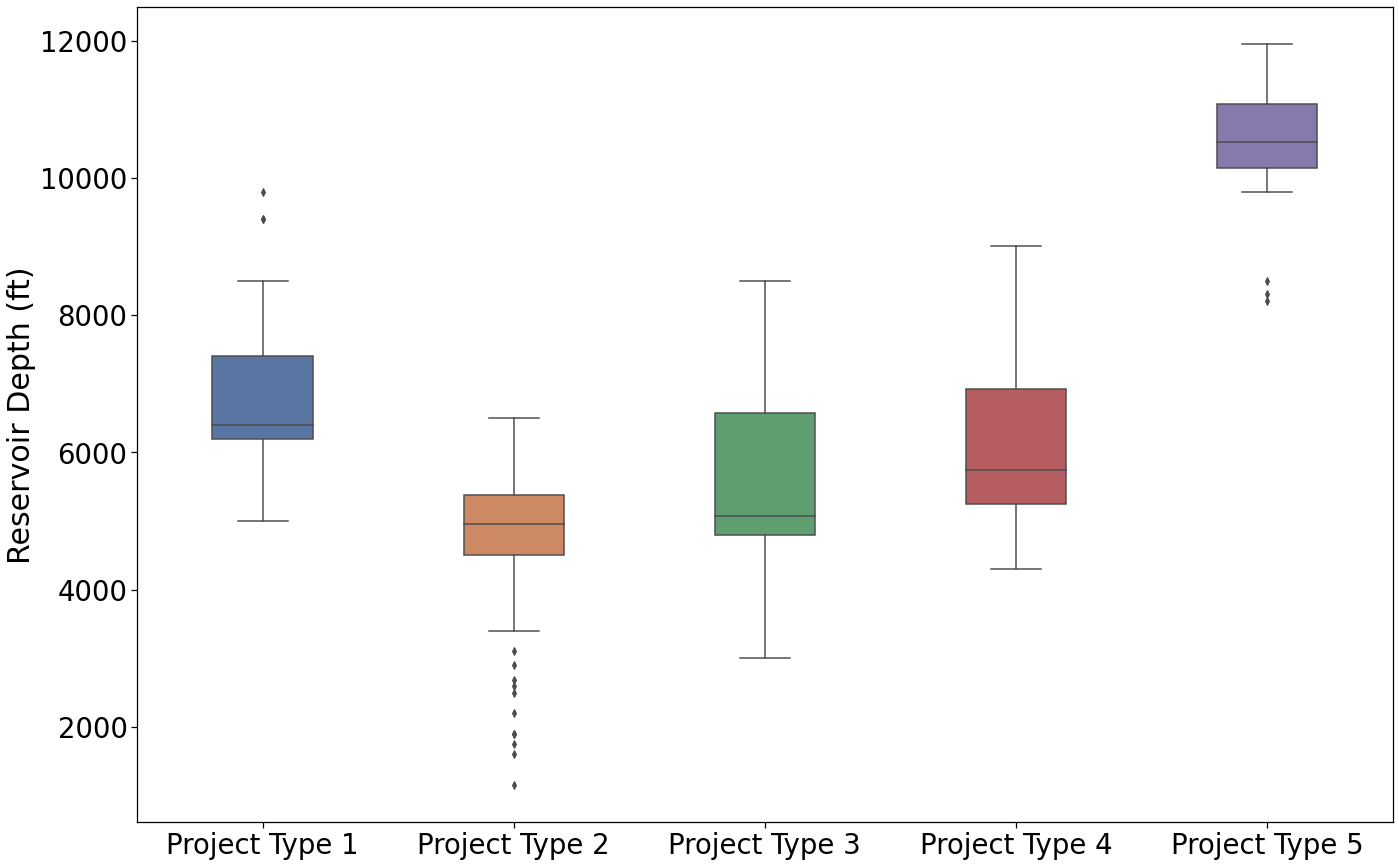

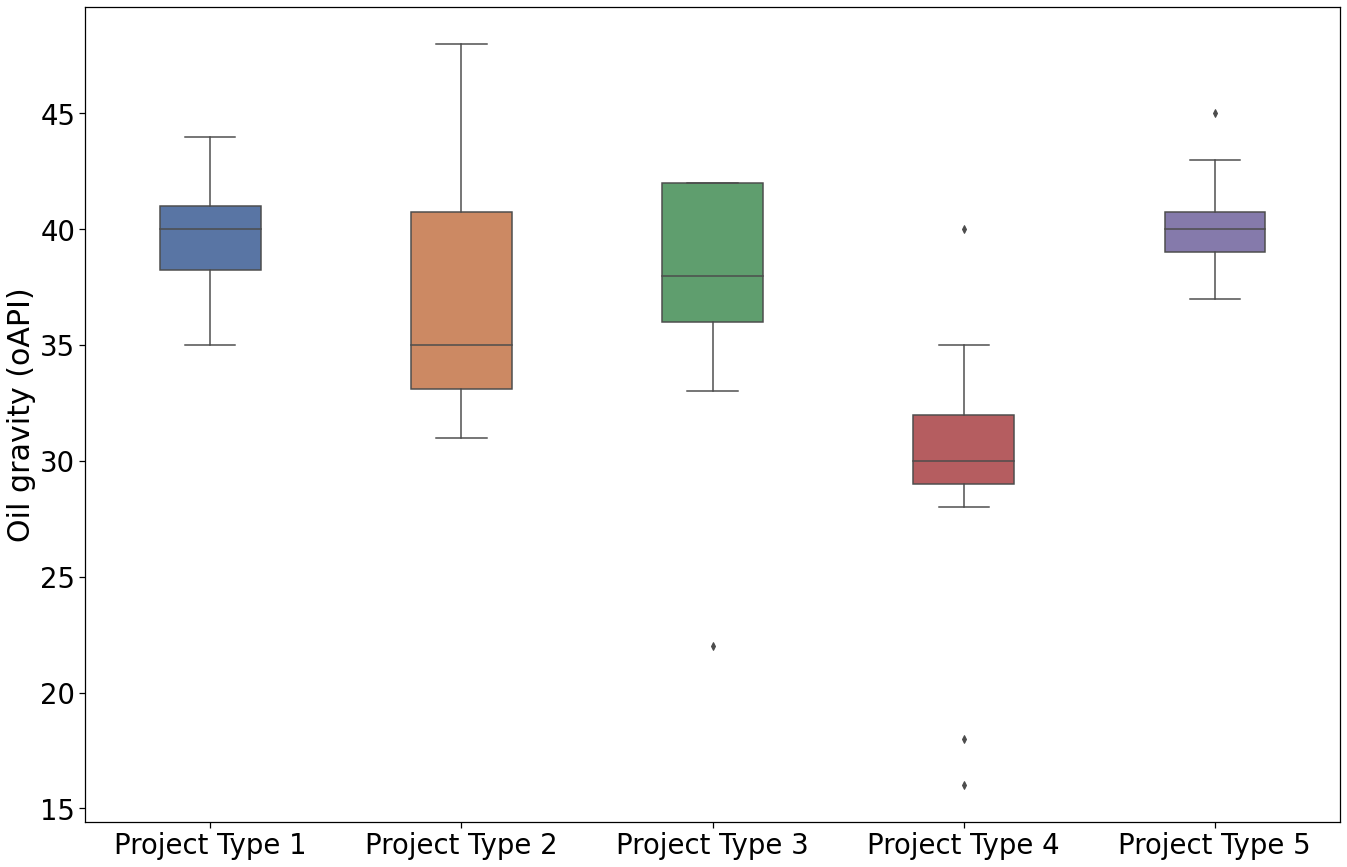

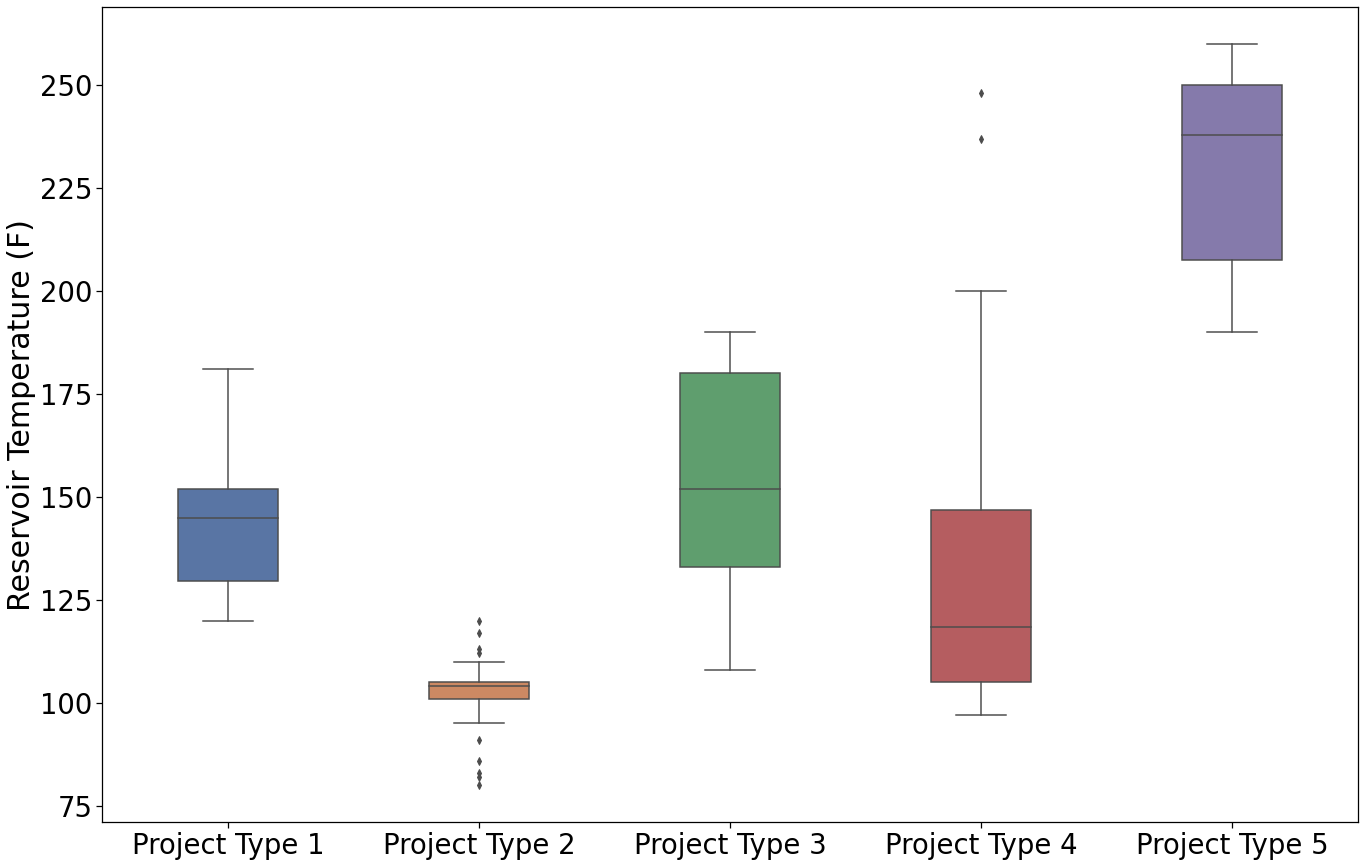

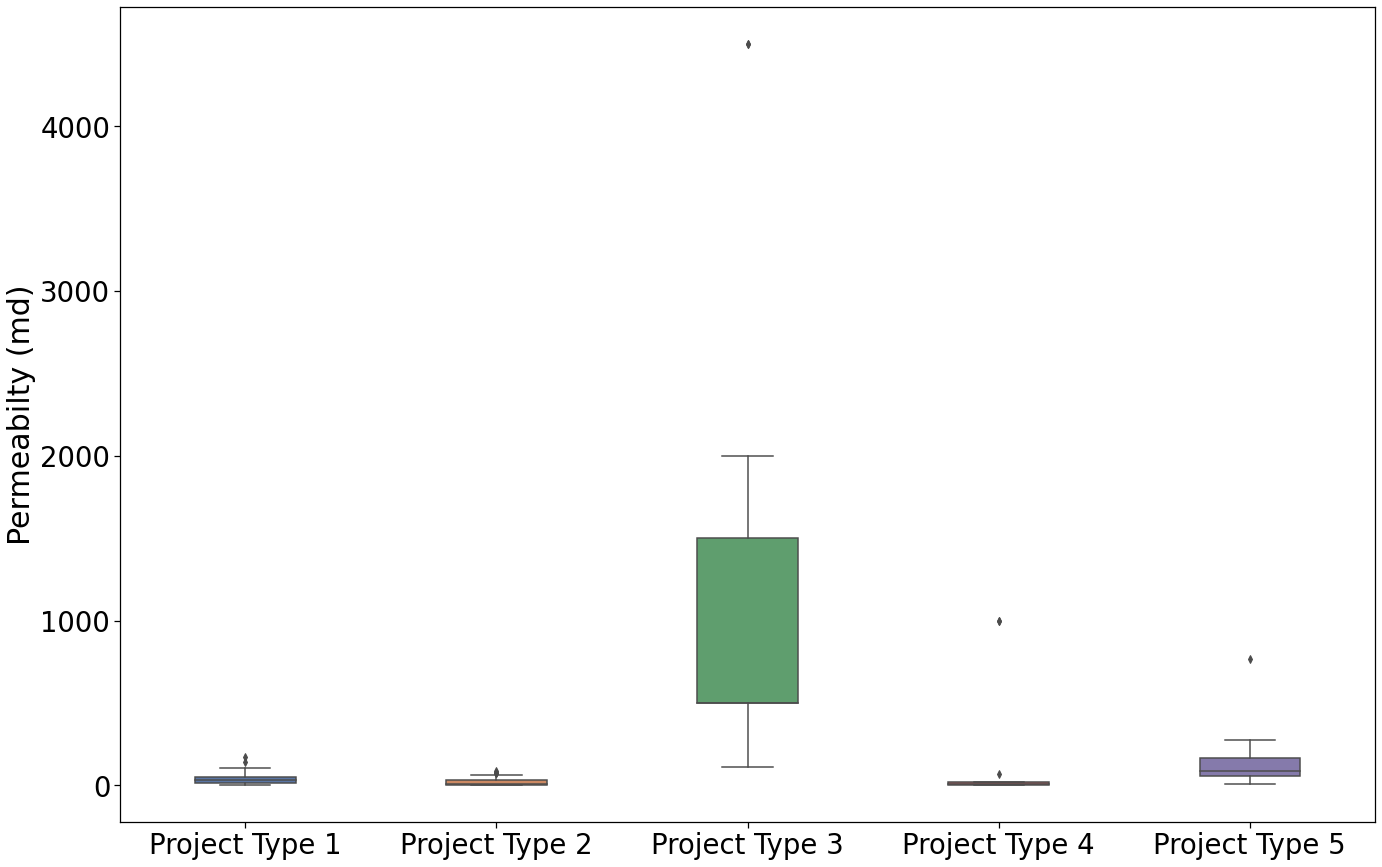

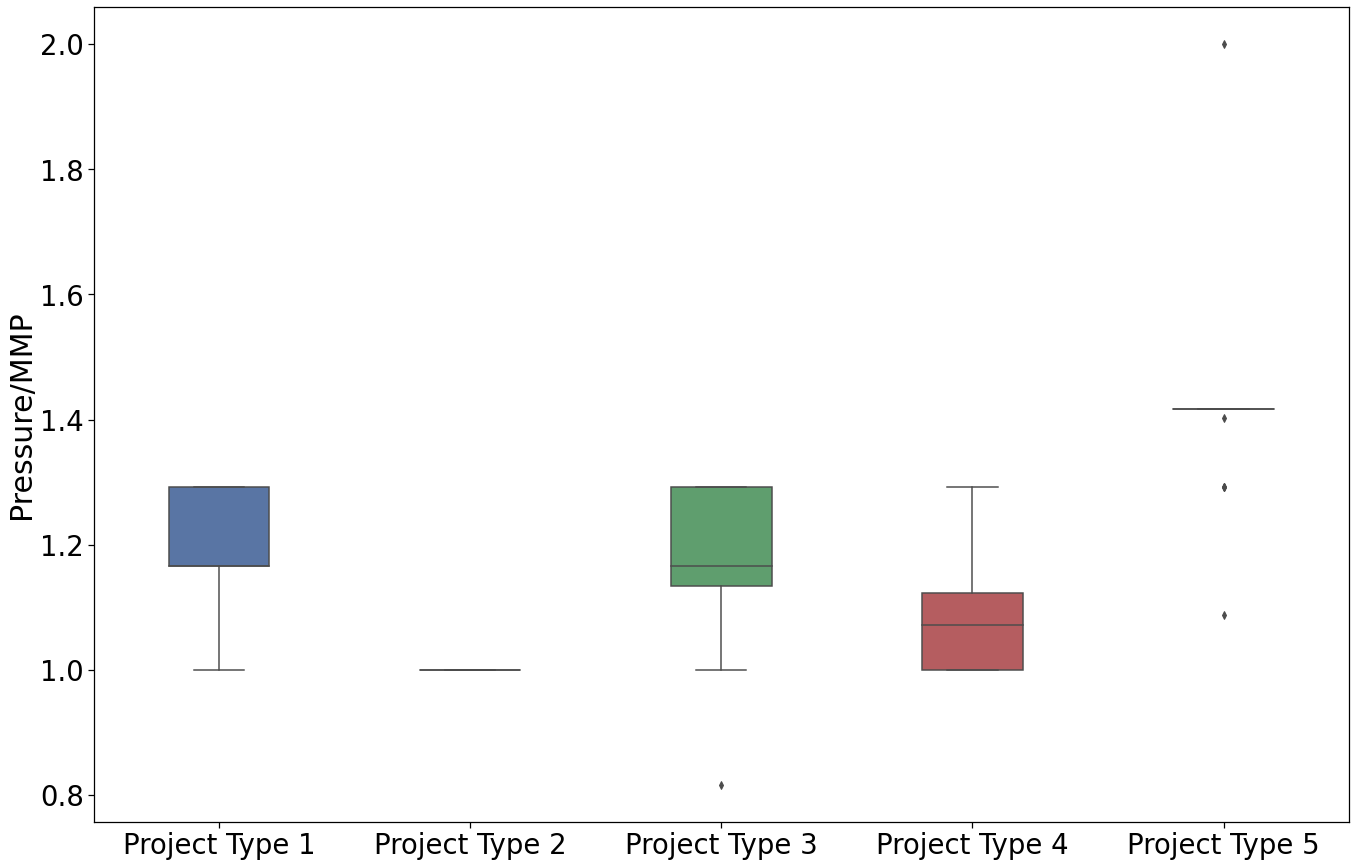

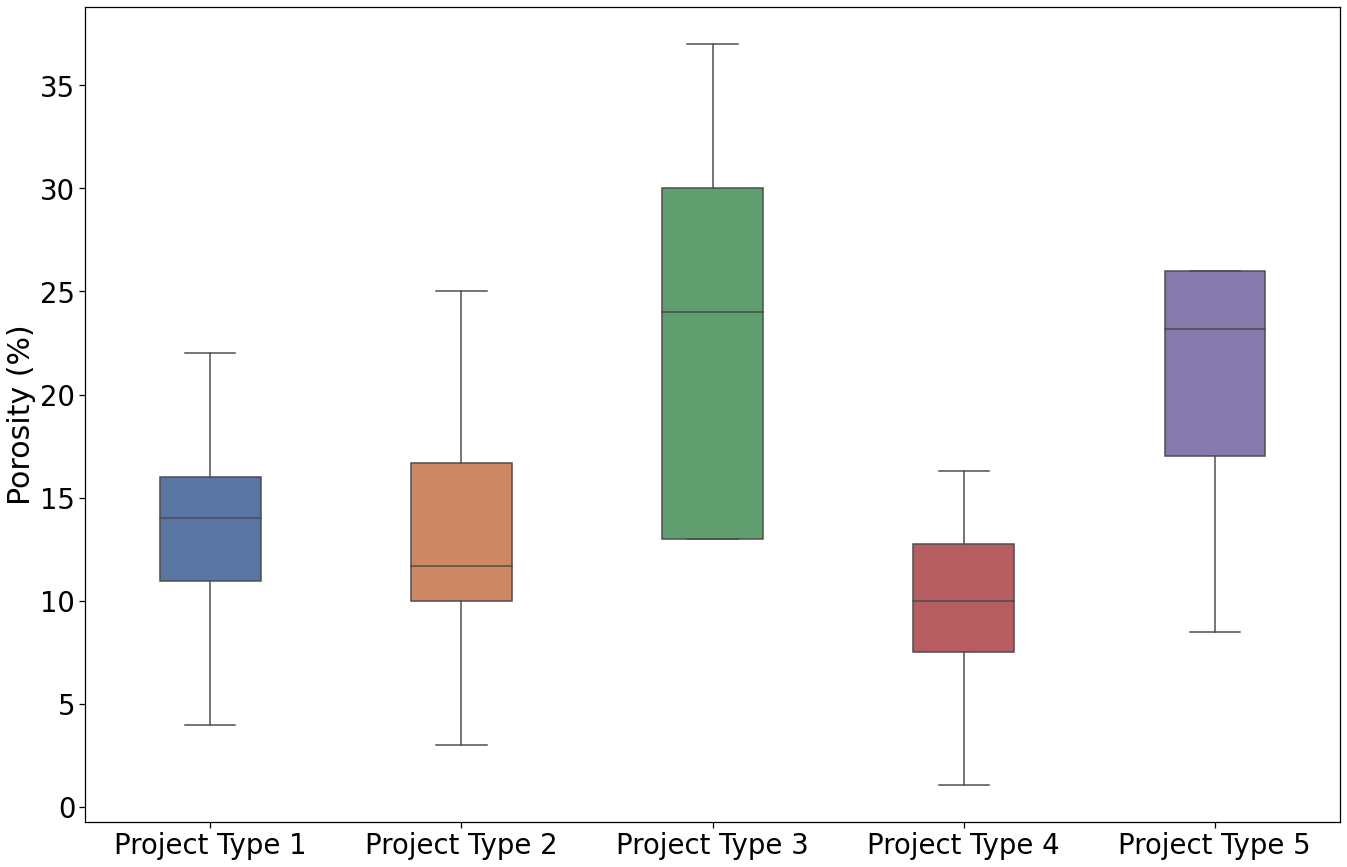

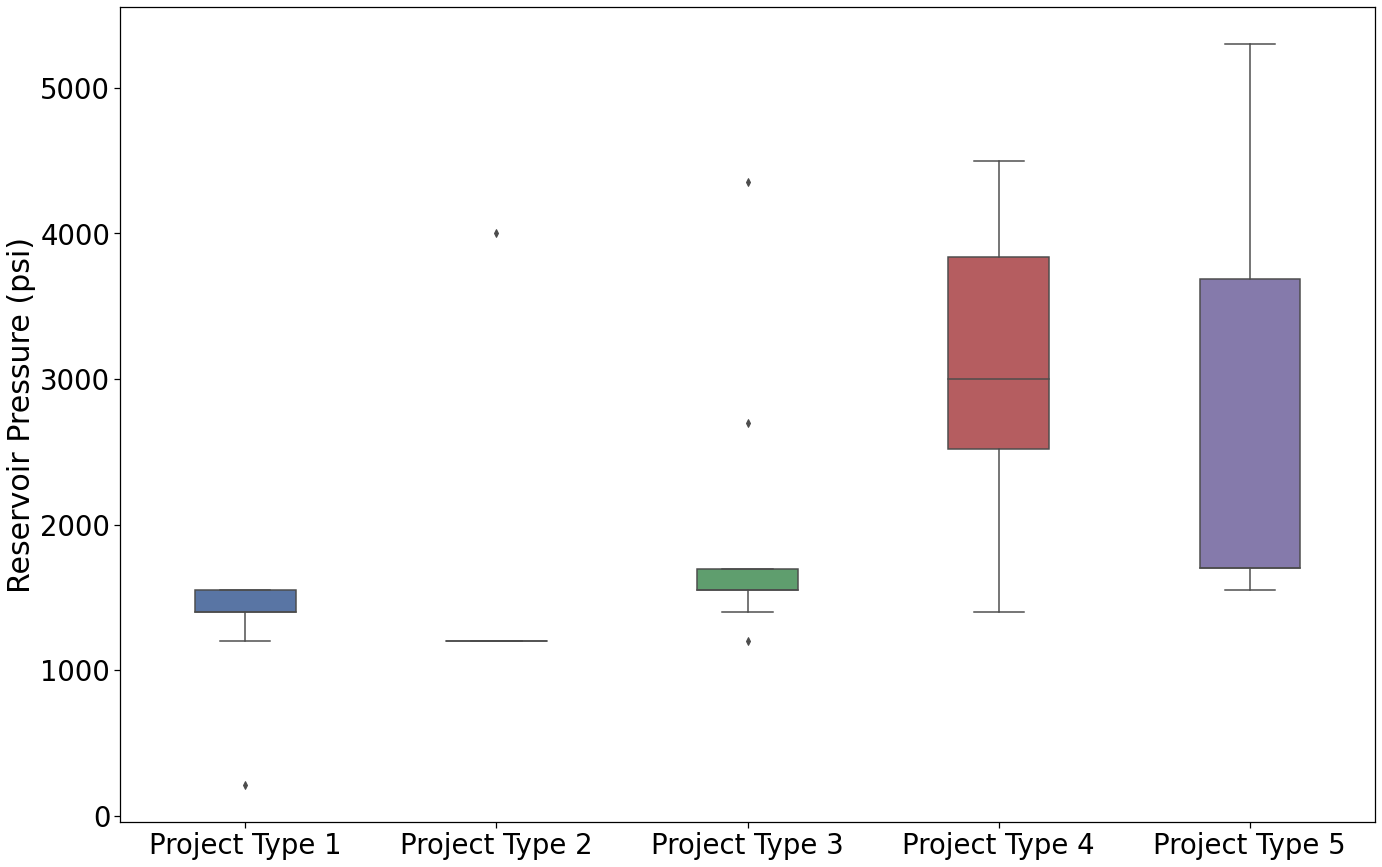

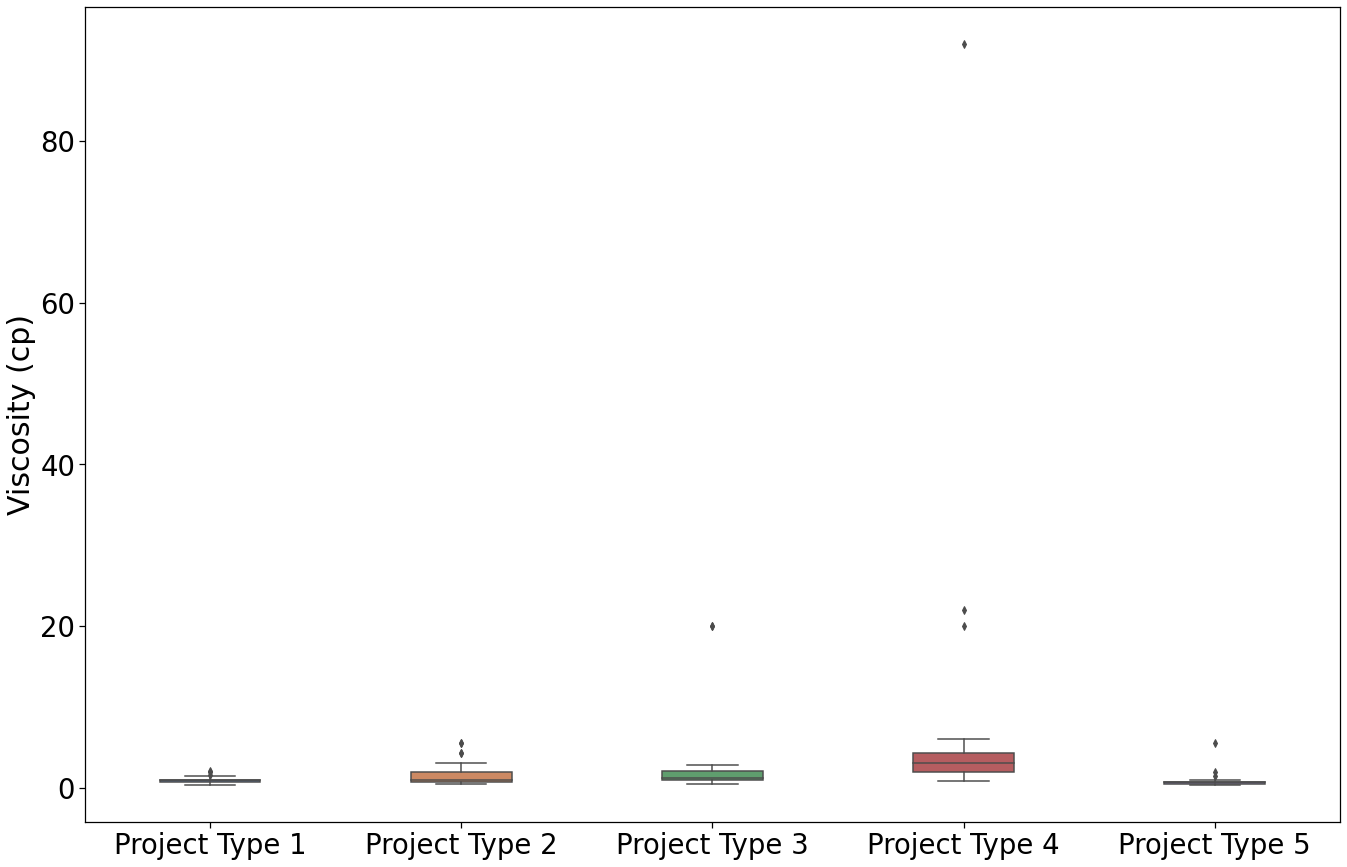

In [ ]:
# Renamed the columns of df_im
df_im.columns = ['Project Type', 'Reservoir Depth (ft)', 'Oil gravity (oAPI)','Reservoir Temperature (F)','Permeabilty (md)','Pressure/MMP','Porosity (%)',	
                 	'Reservoir Pressure (psi)','Viscosity (cp)']

# exclude the cluster number column
column = df_im.drop('Project Type',axis=1).columns

for col in column:
  plt.figure(figsize=(22.5,15))
  sns.boxplot(y=df_im[col], x=df_im['Project Type'], hue = df_im['Project Type'], width = .4, 
              # sym = "", 
              dodge = False, orient = 'v' )
  plt.xticks([0,1, 2, 3,4], ['Project Type 1', 'Project Type 2', 'Project Type 3',
                               'Project Type 4', 'Project Type 5', ])
  plt.xlabel('')
  plt.legend('', frameon=False)
  plt.show()

## Dataset Analysis

### Cluster Characterization




| Project | Area |	Prod_well |	Inj_well |	Formation |	Prev_prod |	Por |	Perm |	Depth |	Temp	| Sat_start |	API |	Visc |
|------:|:-----|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|
| Proj. Type 1|	Large	|High|	High|	Mostly Dolomite|	Two types but mostly WF|	Medium|	Medium|	Medium|	Medium|	Med to high|	low to Med|	Medium|
| Proj. Type 2 |	Small to med|	Low to med|	Low to med|	Mostly Dolomite &Sandstone, most varied |	Various types but mostly WF	|Medium|	Medium|	Medium|	Medium|	Medium|	Med to high|	Med to high|
|Proj. Type 3	|Medium	|Low to med|	Low to med|	Predominantly Sandstone|	Various types but mostly WF|	High|	High|	High|	High|	low to Med|	Medium|	low to Med|




# Project Analogues

## Euclidean distance Calculation

In [ ]:
df_clus.loc[df_clus.Field == 	'Hansford Marmaton']


,ID,Country,State,Latitude,Longitude,Operator,Field,Area,Formation,Depth,API,Temperature,Permeability,Sat_start,Pressure/MMP,Porosity,MMP,Pressure,Viscosity,Principal Component 1,Principal Component 2,Principal Component 3,PCA_Cluster,Cluster
138,145,US,Tex.,40.777727,-95.964714,Stanberry Oil,Hansford Marmaton,2010,Sandstone,6500,44.0,142,48.0,43.0,1.166667,18.1,209,209,2.0,-0.011853,-1.185435,0.102113,0,Project Type 1


In [ ]:
Test_1 = df_clus.loc[df_clus.ID==166] # Locate Weyburn
Test_2 = df_clus.loc[df_clus.ID==145] # Locate Hansford Marmaton
Test_3 = df_clus.loc[df_clus.ID==148] # Locate Paradis

In [ ]:
# Python code to find Euclidean distance
# using linalg.norm()

df_clus['T1_distance'] = np.linalg.norm(df_clus[['Principal Component 1', 'Principal Component 2','Principal Component 3' ]].sub(np.array(Test_1[['Principal Component 1', 'Principal Component 2', 'Principal Component 3']])), axis=1)
df_clus['T2_distance'] = np.linalg.norm(df_clus[['Principal Component 1', 'Principal Component 2','Principal Component 3' ]].sub(np.array(Test_2[['Principal Component 1', 'Principal Component 2', 'Principal Component 3']])), axis=1)
df_clus['T3_distance'] = np.linalg.norm(df_clus[['Principal Component 1', 'Principal Component 2','Principal Component 3' ]].sub(np.array(Test_3[['Principal Component 1', 'Principal Component 2', 'Principal Component 3']])), axis=1)


In [ ]:
df_clus.sort_values(by = ['T1_distance']).head(31)

,ID,Country,State,Latitude,Longitude,Operator,Field,Area,Formation,Depth,API,Temperature,Permeability,Sat_start,Pressure/MMP,Porosity,MMP,Pressure,Viscosity,Principal Component 1,Principal Component 2,Principal Component 3,PCA_Cluster,Cluster,T1_distance,T2_distance,T3_distance
158,166,Canada,Sask.,63.177445,-101.627138,Cenovus,Weyburn Unit,17280,Carbonates,4655,28.0,140,10.0,45.00,1.117371,15.0,1704,1904,3.000000,-0.542106,2.036751,0.081498,3,Project Type 4,0.000000,3.265590,4.437813
98,105,US,Tex.,40.491869,-95.331832,Occidental,Cedar Lake,2870,Carbonates,4800,32.0,102,5.0,50.00,1.000000,14.0,4000,4000,2.300000,-0.930286,1.909516,0.090905,3,Project Type 4,0.408609,3.228369,4.741386
156,164,Canada,Sask.,62.687174,-102.175398,Apache Canada,Midale,30483,Carbonates,4600,30.0,149,7.5,45.00,1.066667,16.3,3000,3200,3.000000,-0.302278,2.415261,0.254541,3,Project Type 4,0.480345,3.615604,4.372239
101,108,US,Tex.,41.995874,-95.365661,Occidental,GMK South,1143,Carbonates,5400,30.0,101,3.0,55.00,1.000000,10.0,3000,3000,3.000000,-0.975809,2.505573,-0.281999,3,Project Type 4,0.734861,3.834096,5.092294
97,104,US,Tex.,41.530920,-95.138503,Occidental,Benneth Ranch Unit,830,Carbonates,5200,29.0,109,7.0,55.00,1.000000,10.0,4000,4000,3.000000,-0.936185,2.598997,-0.219942,3,Project Type 4,0.749856,3.908968,5.087312
96,103,US,Tex.,40.826310,-96.020945,Occidental,Anton Irish,4437,Carbonates,5800,30.0,109,4.0,50.00,1.000000,7.0,4000,4000,3.000000,-0.858836,2.582075,-0.589131,3,Project Type 4,0.920564,3.922923,5.103798
70,76,US,Tex.,42.233394,-95.241728,Fasken,Hanford,1120,Carbonates,5500,32.0,104,4.0,60.70,1.072340,10.5,2350,2520,1.000000,-0.522902,1.278853,-0.520532,3,Project Type 4,0.968101,2.592600,4.319605
71,77,US,Tex.,41.456151,-96.576629,Fasken,Hanford East,340,Carbonates,5500,32.0,105,4.0,45.00,1.072340,10.0,2350,2520,1.000000,-0.525682,1.291076,-0.558830,3,Project Type 4,0.983016,2.614187,4.337328
12,14,US,Okla.,43.688150,-94.022707,Chaparral Energy,Sho-Vel-Turn,1100,Sandstone,6200,30.0,115,70.0,59.00,1.000000,16.0,3000,3000,0.826561,0.044310,1.307796,0.406742,3,Project Type 4,0.990476,2.512400,3.589061
72,78,US,Tex.,40.948936,-94.983466,Fasken,Hanford (San Andres),150,Carbonates,5700,32.0,105,5.0,50.00,1.072340,10.0,2350,2520,1.000000,-0.467161,1.291068,-0.590653,3,Project Type 4,1.006701,2.611569,4.294362


In [ ]:
df_clus.sort_values(by = ['T2_distance']).head(50)

,ID,Country,State,Latitude,Longitude,Operator,Field,Area,Formation,Depth,API,Temperature,Permeability,Sat_start,Pressure/MMP,Porosity,MMP,Pressure,Viscosity,Principal Component 1,Principal Component 2,Principal Component 3,PCA_Cluster,Cluster,T1_distance,T2_distance,T3_distance
138,145,US,Tex.,40.777727,-95.964714,Stanberry Oil,Hansford Marmaton,2010,Sandstone,6500,44.0,142,48.00,43.00,1.166667,18.1,209,209,2.000000,-0.011853,-1.185435,0.102113,0,Project Type 1,3.265590,0.000000,3.805793
111,118,US,Tex.,41.315657,-96.388432,Occidental,Sharon Ridge,1400,Carbonates,6600,43.0,125,70.00,39.00,1.166667,10.0,1200,1400,0.400000,0.204167,-1.003239,-0.350470,0,Project Type 1,3.159915,0.533564,3.664368
161,169,Canada,Alberta,63.856225,-112.423161,Penn West Energy Trust,Pembina,80,Sandstone,5300,41.0,128,20.00,48.03,1.166667,16.0,1200,1400,1.000000,-0.263079,-0.669834,-0.098366,0,Project Type 1,2.726868,0.607578,3.926908
110,117,US,Tex.,42.315885,-95.514069,Occidental,Salt Creek,12000,Carbonates,6300,39.0,125,12.00,89.00,1.166667,20.0,1200,1400,1.000000,0.018583,-0.604171,-0.103645,0,Project Type 1,2.706127,0.617357,3.648106
107,114,US,Tex.,41.534197,-94.280959,Occidental,North Dollarhide Devonian,1280,Carbonates,7500,40.0,123,5.00,38.00,1.166667,22.0,1200,1400,0.500000,0.389939,-0.986146,-0.324392,0,Project Type 1,3.189258,0.618918,3.486533
16,18,US,Okla.,44.795996,-93.012865,Breitburn Energy,Postle-HMU,5415,Sandstone,6200,40.0,145,25.00,75.00,1.166667,16.0,1200,1400,0.730714,0.194021,-0.699430,-0.302018,0,Project Type 1,2.859311,0.664760,3.566647
15,17,US,Okla.,44.947551,-92.733087,Breitburn Energy,Postle-WHMU,7724,Sandstone,6200,40.0,145,25.00,75.00,1.166667,16.0,1200,1400,0.737733,0.193477,-0.695852,-0.301261,0,Project Type 1,2.855645,0.666755,3.565965
14,16,US,Okla.,44.878914,-92.769956,Breitburn Energy,Postle-HMAU,3396,Sandstone,6200,40.0,145,25.00,75.00,1.166667,16.0,1200,1400,0.737733,0.193477,-0.695852,-0.301261,0,Project Type 1,2.855645,0.666755,3.565965
150,157,US,Okla.,43.668231,-92.080988,Whiting Petroleum,Postle,21000,Sandstone,6200,40.0,145,50.00,37.00,1.166667,16.0,1200,1400,1.000000,0.294311,-0.557020,-0.020030,0,Project Type 1,2.727187,0.709621,3.357011
149,156,US,Okla.,44.863673,-92.596284,Whiting Petroleum,Postle,11000,Sandstone,6200,40.0,145,50.00,37.00,1.166667,16.0,1200,1400,1.000000,0.294311,-0.557020,-0.020030,0,Project Type 1,2.727187,0.709621,3.357011


In [ ]:
df_clus.sort_values(by = ['T3_distance']).head(50)

,ID,Country,State,Latitude,Longitude,Operator,Field,Area,Formation,Depth,API,Temperature,Permeability,Sat_start,Pressure/MMP,Porosity,MMP,Pressure,Viscosity,Principal Component 1,Principal Component 2,Principal Component 3,PCA_Cluster,Cluster,T1_distance,T2_distance,T3_distance
141,148,US,La.,39.498827,-87.213242,Texaco,Paradis,44,Sandstone,9800,38.0,192,252.0,45.00,1.291667,24.0,4000,4350,0.350000,3.441410,0.233879,0.840072,4,Project Type 5,4.437813,3.805793,0.000000
142,149,US,La.,39.448742,-88.363130,Texaco/MVP,Paradis,298,Sandstone,9950,38.0,190,245.0,44.00,1.291667,24.0,4000,4350,0.350000,3.460210,0.230334,0.812196,4,Project Type 5,4.451472,3.816261,0.033809
143,150,US,La.,40.422828,-87.562295,Texaco/MVP,Paradis,102,Sandstone,11400,38.5,192,162.0,45.00,1.087500,26.0,4000,4350,0.300000,3.361893,0.248810,0.767243,4,Project Type 5,4.348355,3.725805,0.108857
140,147,US,La.,40.564951,-87.288022,Texaco,Paradis,347,Sandstone,10400,37.0,205,770.0,62.00,1.416667,26.0,4000,4350,0.500000,4.112315,0.292252,0.751825,4,Project Type 5,5.015601,4.428820,0.679197
51,57,US,Miss.,42.174526,-81.518333,Denbury Resources,East Mallalieu,880,Sandstone,10550,40.0,248,75.0,52.00,1.416667,26.0,1200,1700,1.907694,3.736972,0.069835,-0.187299,4,Project Type 5,4.717151,3.963982,1.081554
62,68,US,Tex.,41.602062,-95.481502,Denbury Resources,Oyster Bayou,3900,Sandstone,8500,39.5,190,2000.0,26.70,1.291667,28.0,1200,1550,0.894121,2.705766,-0.626909,1.372871,2,Project Type 3,4.394474,3.051595,1.251400
59,65,US,Miss.,41.667006,-81.351733,Denbury Resources,Cranfield,7754,Sandstone,10300,39.0,260,100.0,32.00,1.416667,26.0,1200,1700,0.599379,4.009250,-0.492571,-0.050560,4,Project Type 5,5.208623,4.083215,1.281951
77,84,US,Tex.,40.779545,-95.177064,George R. Brown,Rose City South,900,Sandstone,8200,37.0,180,4500.0,50.00,1.291667,37.0,1200,1550,2.000000,2.461597,0.071306,1.717595,2,Project Type 3,3.944873,3.210473,1.325333
76,83,US,Tex.,41.355959,-95.456611,George R. Brown,Rose City North,800,Sandstone,8200,37.0,180,4500.0,50.00,1.291667,37.0,1200,1550,2.000000,2.461597,0.071306,1.717595,2,Project Type 3,3.944873,3.210473,1.325333
144,151,US,Tex.,41.401882,-96.589774,Texaco,Garden Island Bay,91,Sandstone,8000,36.0,190,500.0,48.00,1.291667,29.0,1200,1550,0.500000,2.587455,-0.572377,1.487104,2,Project Type 3,4.310154,3.008396,1.340872


# Saving to CSV file

In [ ]:
#Save to CSV File
df_clus.to_csv ('CO2_projects_clusters.csv', index = False, header=True)